# Results evaluator
This notebook uses the images folders generated using [PIPELINE 1], the image metrics generated using [PIPELINE 2], the model error and confidence from [KITTI ADS] or [DONKEY ADS], and the attention mask error calculated using [PIPELINE 3] to evaluate results.

## Usage:
Run all cells

## Requirements:
"./[type]/content/output_plots/[source]/[source]"
"./[type]/content/output_plots/[source]/[source]_mask"
"./[type]/content/output_plots/[source]/[source]_mask_error"
"./[type]/content/output_plots/[source]/[source]_additional_mask"
"./[type]/content/output_plots/[source]/[source]_metrics_results"
"./[type]/content/output_plots/[source]/[source]_pred"
"./[type]/content/output_plots/[source]/[source]_[ADS]_conf"
"./[type]/content/output_plots/[source]/[source]_[ADS]_loss"
"./[type]/content/output_plots/[source]/[source]_att_loss" 

In [1]:
from scipy.stats import pearsonr

In [2]:
import cv2, os, glob, re, json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

In [3]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

In [4]:
type="kitti"
data_directory="./"+type+"/content/output_plots/"
sources={}

sources['sim']=['sim']
sources['real']=['real']
# sources['cyclegan']=["cyclegan_1","cyclegan_2","cyclegan_3"]
# sources['pix2pix_mask_manual']=["pix2pix_mask_1_sim","pix2pix_mask_2_sim","pix2pix_mask_3_sim"]

if type=="kitti":
    sources['cyclegan']=["cyclegan_1","cyclegan_8","cyclegan_28"]
    # ,"cyclegan_19","cyclegan_40"
    # ,"pix2pix_mask_39_real","pix2pix_mask_46_real","pix2pix_mask_57_real","pix2pix_mask_108_real","pix2pix_mask_125_real","pix2pix_mask_159_real","pix2pix_mask_240_real","pix2pix_mask_270_real","pix2pix_mask_290_real"
    sources['pix2pix_mask_manual']=["pix2pix_mask_39_sim","pix2pix_mask_57_sim","pix2pix_mask_290_sim"]
    # ,"pix2pix_mask_125_sim","pix2pix_mask_240_sim",
elif type=="donkey":
    sources['cyclegan']=['cyclegan_2','cyclegan_4','cyclegan_5']
    # ,"cyclegan_2",'cyclegan_3','cyclegan_4','cyclegan_5',"cyclegan_6"
    sources['pix2pix_mask_manual']=['pix2pix_mask_20_sim','pix2pix_mask_70_sim','pix2pix_mask_120_sim']

plot=True
if type=="kitti":
    height,width=374,1238
    road=0
    additional_id=3
    additional_id_init=13
    dataset_ids=["*"]
    # 0001","0002","0006","0018","0020
elif type=="donkey":
    height,width=140,320
    road=1
    additional_id=1
    additional_id_init=2
    dataset_ids=["0001"]

image_path_dict={}
mask_path_dict={}
mask_additional_path_dict={}
mask_error_path_dict={}
image_metrics_path_dict={}
model_path_dict={}
model_loss_path_dict={}
model_conf_path_dict={}
model_att_path_dict={}

In [5]:
for model_type, models in sources.items():
    for source_name in models:
        image_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"/"
        mask_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_mask/"
        mask_error_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_mask_error/"
        mask_additional_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_additional_mask/"
        image_metrics_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_metrics_results/"
        if type=="kitti":
            model_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_pred/"
            model_loss_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_yolo_loss/"
            model_conf_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_yolo_conf/"
            model_att_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_att_loss/"
        elif type=="donkey":
            model_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_pred/"
            model_loss_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_driver_loss/"
            model_conf_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_driver_conf/"
            model_att_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_att_loss/"

In [6]:
from numpy import inf
import operator
def min_max_normalize(data):
    # Implementation of min-max normalization
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def cast_to_int32(image):
    # Normalize the image pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Convert to uint8 by scaling the values back to [0, 255]
    image = tf.cast(image * 255, tf.int32)
    return image

/Users/lambertenghi/miniconda3/envs/tfEnv4/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


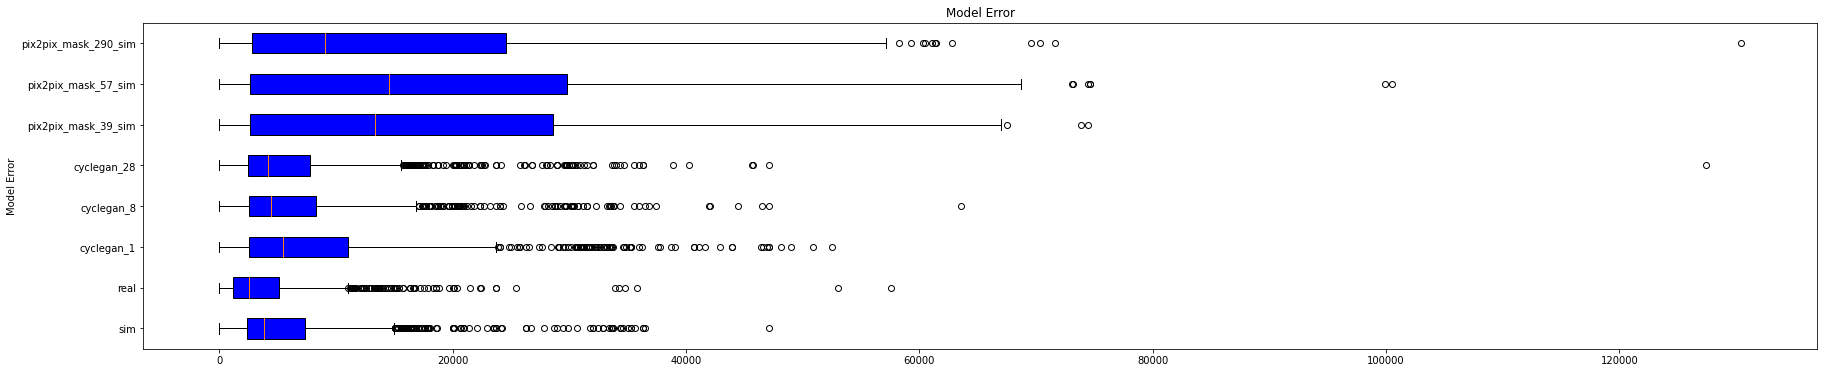

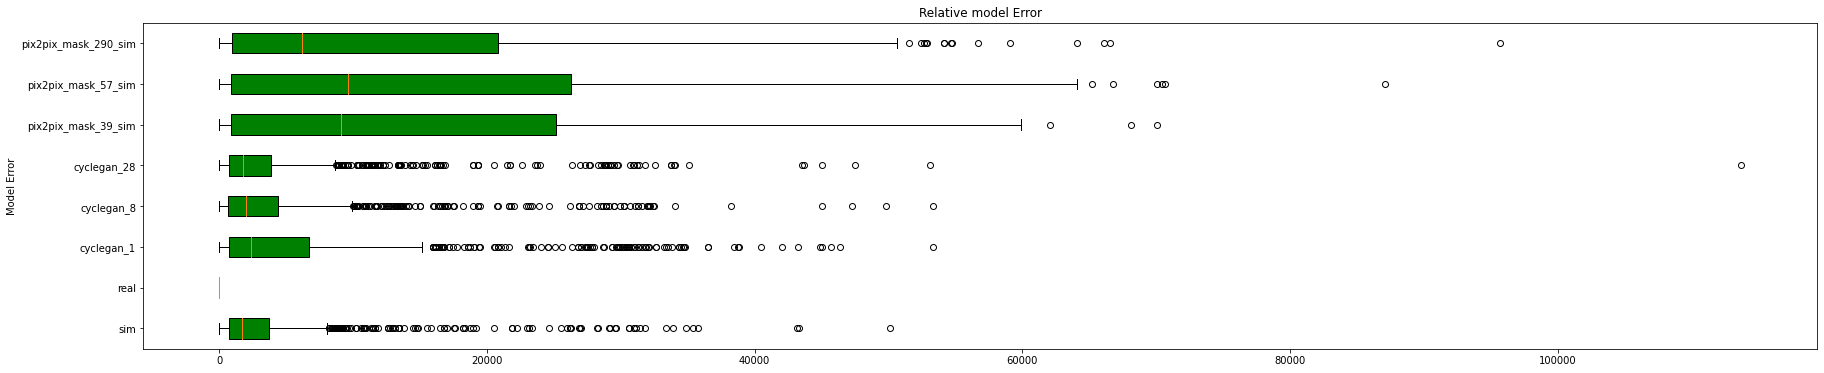

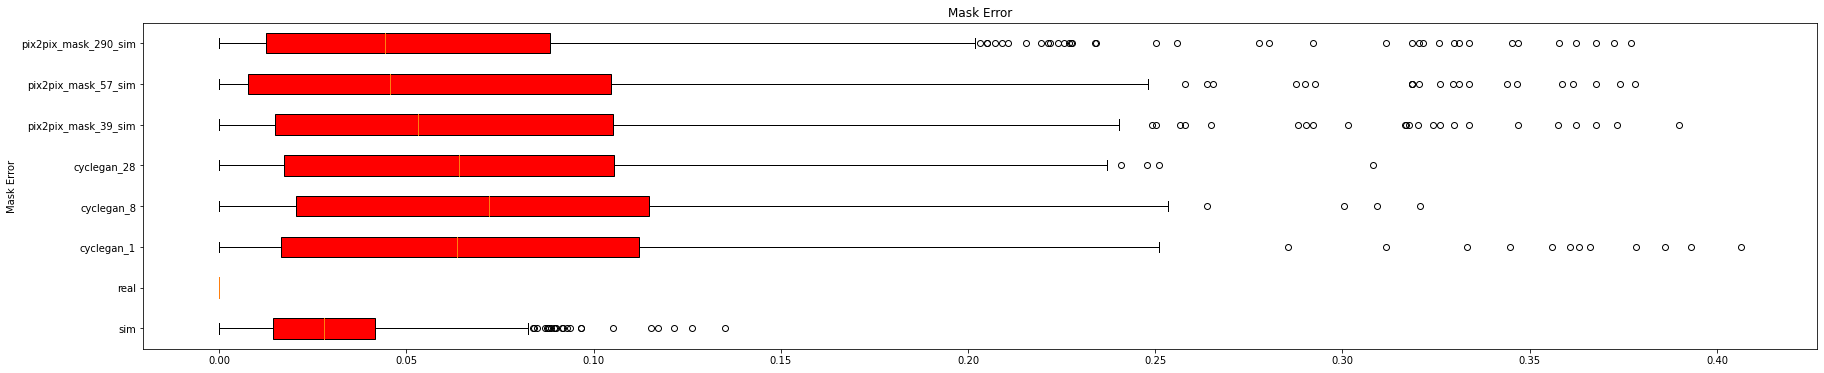

/Users/lambertenghi/miniconda3/envs/tfEnv4/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


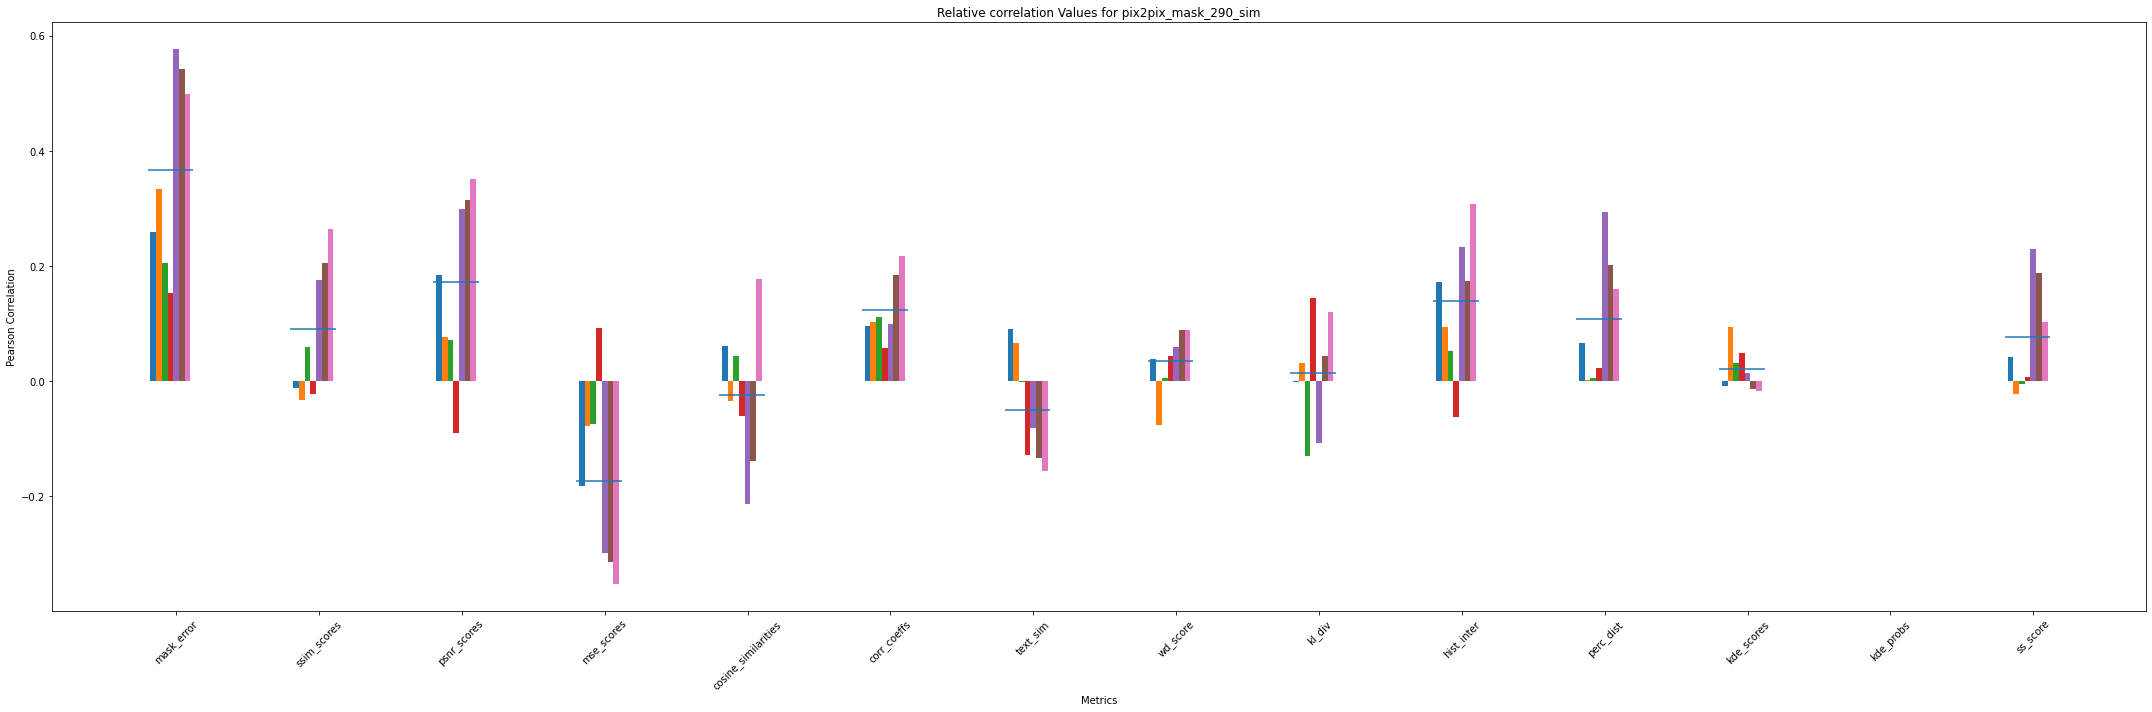

In [7]:
for dataset_id in dataset_ids:
    # print("plots for dataset: ",dataset_id)
    # print(sources)
    data_list=sorted(glob.glob(data_directory+'cyclegan/'+sources['cyclegan'][0]+'/'+dataset_id+'_*.png'),key=natural_sort_key)
    filenames=[]
    for path in data_list:
        filenames.append(path.split("/")[-1].split(".")[0])
    # print(len(filenames))
    
    image_metrics=[]
    with open(image_metrics_path_dict['sim__'+sources['sim'][0]]+filenames[0]+".json", "r") as json_file:
                    error_data = json.load(json_file)
                    for key, value in error_data.items():
                        image_metrics.append(key)
    mask_errors=[]
    with open(mask_error_path_dict['cyclegan__'+sources['cyclegan'][0]]+filenames[0]+".json", "r") as json_file:
                    error_data = json.load(json_file)
                    for key, value in error_data.items():
                        mask_errors.append(key)
                        
    model_loss_dict={}
    model_conf_dict={}
    image_metrics_dict={}
    mask_error_dict={}
    model_att_dict={}
    for model_type, models in sources.items():
        for source_name in models:
            model_loss_dict[model_type+"__"+source_name]=[]
            model_conf_dict[model_type+"__"+source_name]=[]
            model_att_dict[model_type+"__"+source_name]=[]
            image_metrics_dict[model_type+"__"+source_name]={}
            mask_error_dict[model_type+"__"+source_name]={}
            for image_metric in image_metrics:
                image_metrics_dict[model_type+"__"+source_name][image_metric]=[]
            if(source_name!='real'):
                for mask_error in mask_errors:
                    mask_error_dict[model_type+"__"+source_name][mask_error]=[]
    # print(mask_error_dict)
    
    for file in filenames:
        for model_type, models in sources.items():
            for source_name in models:
                    if(source_name!='real'):
                        with open(mask_error_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
                            error_data = json.load(json_file)
                            for key, value in error_data.items():
                                        if source_name=='sim' and key=='sim_real':
                                            mask_error_dict[model_type+"__"+source_name][key].append(float(value))
                                            mask_error_dict[model_type+"__"+source_name]['real'].append(float(value))
                                        else:
                                            mask_error_dict[model_type+"__"+source_name][key].append(float(value))
                    
                
                        with open(image_metrics_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
                            error_data = json.load(json_file)
                            
                            for metric_name, value in error_data.items():
                                        if (metric_name == 'kde_probs' or metric_name == 'inception_score' or metric_name == 'inception_std_score' or metric_name=="kid_score" or metric_name=="fid_score"):
                                            image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
                                        elif metric_name!='perceptual_distances':
                                            
                                            image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
                    # if type=="kitti":
                    f = open(model_loss_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_loss=float(f.read())
                    model_loss_dict[model_type+"__"+source_name].append(model_loss)

                    f = open(model_conf_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_conf=float(f.read())
                    model_conf_dict[model_type+"__"+source_name].append(model_conf)

                    f = open(model_att_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_att=float(f.read())
                    model_att_dict[model_type+"__"+source_name].append(model_att)

    
    correlation_dict={}
    relative_correlation_dict={}

    y_min_model = min(np.min(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    y_max_model = max(np.max(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    y_max_mask=0
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                            
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            # print("new:",max(new_list),"todo:",max(mask_error))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            y_max_mask=max(max(mask_error),y_max_mask)
    
    
    y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    for model_type, models in sources.items():
            for source_name in models:
                correlation_dict[model_type+"__"+source_name]={}
                relative_correlation_dict[model_type+"__"+source_name]={}
                if(source_name!='real' and source_name!='real'):
                            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
                            relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            pears=pearsonr(model_loss_dict[model_type+"__"+source_name], mask_error)
                            pears_rel=pearsonr(relative_loss, mask_error)
                            correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
                            relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel
                            for image_metric in image_metrics:
                                if(metric_name == 'kde_probs' or image_metric!="inception_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
                                    metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]
                                    metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
                                    metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
                                    pears=pearsonr(model_loss_dict[model_type+"__"+source_name], metric_vals)
                                    correlation_dict[model_type+"__"+source_name][image_metric]=pears
                                    pears_rel=pearsonr(relative_loss, metric_vals)
                                    relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel
    
    all_model_errors = []
    relative_model_errors = []
    all_mask_errors = []
    
    for model_type, models in sources.items():
        for source_name in models:
                # Create a list of model errors (you can modify this depending on your data structure)
            model_errors = model_loss_dict[model_type + "__" + source_name]
            if model_type!='real':
                mask_errors = mask_error_dict[model_type+"__"+source_name]["additional"]
            else:
                mask_errors = [0 for i in range(0, len(model_loss_dict[model_type+"__"+source_name]))]
            # Append the model errors to the list
            all_model_errors.append(model_errors)
            all_mask_errors.append(mask_errors)
            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
            relative_model_errors.append(relative_loss)
    
    # Create a single box plot for all sources
    fig, ax1 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
    fig, ax2 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
    fig, ax3 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
    ax1.set_title("Model Error")
    ax1.set_ylabel("Model Error")
    ax2.set_title("Relative model Error")
    ax2.set_ylabel("Model Error")
    ax3.set_title("Mask Error")
    ax3.set_ylabel("Mask Error")
    
    # Create the box plot with all the model errors
    boxes1 = ax1.boxplot(all_model_errors, vert=False, patch_artist=True)
    boxes2 = ax2.boxplot(relative_model_errors, vert=False, patch_artist=True)
    boxes3 = ax3.boxplot(all_mask_errors, vert=False, patch_artist=True)
    
    # Set x-axis labels based on source names
    source_names = [source_name for model_type, models in sources.items() for source_name in models]
    ax1.set_yticklabels(source_names)
    ax2.set_yticklabels(source_names)
    ax3.set_yticklabels(source_names)
    
    for box in boxes1['boxes']:
        box.set_facecolor('blue')
    for box in boxes2['boxes']:
        box.set_facecolor('green')
    for box in boxes3['boxes']:
        box.set_facecolor('red')
    
    plt.show()                   
    
    count=1
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                    correlations = correlation_dict.get(model_type+"__"+source_name, {})
                    rel_correlations = relative_correlation_dict.get(model_type+"__"+source_name, {})
                    width=0.4
                    width2=0.4
                    ind = np.arange(len(correlations.keys()))
                    plt.bar(ind+width/10*count, [correlation[0] for correlation in relative_correlation_dict[model_type+"__"+source_name].values()], width/10, label='Relative correlation '+model_type+"__"+source_name)
                    count=count+1
    avg_dict={}
    for i,model in enumerate(relative_correlation_dict.keys()):
        correlations=relative_correlation_dict[model]
        for metric in correlations.keys():
            avg_dict[metric]=[]
    for i,model in enumerate(relative_correlation_dict.keys()):
        correlations=relative_correlation_dict[model]
        for metric in correlations.keys():
            avg_dict[metric].append(correlations[metric][0])

    for i,key in enumerate(avg_dict.keys()):
        avg_corr=np.mean(avg_dict[key])
        plt.hlines(avg_corr, i, i+count*width/10, colors=None, linestyles='solid')
    plt.title(f"Relative correlation Values for {source_name}")
    plt.xlabel("Metrics")
    plt.ylabel("Pearson Correlation")
    plt.xticks(rotation=45)
    plt.xticks(ind + width / 2, correlations.keys())
    plt.tight_layout()
    # plt.legend(loc='right')
    plt.show()         

In [8]:
# for model_type, models in sources.items():
#     for source_name in models:
#         if source_name != 'real' and source_name != 'sim':
#             correlations = relative_correlation_dict.get(model_type + "__" + source_name, {})
#             print(f"Model Type: {model_type}, Source Name: {source_name}")
#             for metric, correlation in correlations.items():
#                 print(f"{metric} - Correlation: {correlation[0]}, p-value: {correlation[1]}")

In [9]:
from tabulate import tabulate

# Create a dictionary to organize the correlation data
correlation_dict = {}

# Iterate through the models and sources
for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            correlations = relative_correlation_dict.get(model_type + "__" + source_name, {})
            for metric, correlation in correlations.items():
                if metric not in correlation_dict:
                    correlation_dict[metric] = {}
                correlation_dict[metric][source_name] = {"Correlation": correlation[0], "p-value": correlation[1]}

# Define the headers for the table
all_source_names = sources['cyclegan'] + sources['pix2pix_mask_manual']
table_headers = ["Metric"] + [f"{source_name}" for source_name in all_source_names]

# Add a row before the data to indicate that you are showing both value and correlation
table_headers.insert(1, "Value")

# Organize data for each metric
table_data = []
for metric, source_correlations in correlation_dict.items():
    metric_row = [metric]
    for source_name in all_source_names:
        if source_name in source_correlations:
            correlation_data = source_correlations[source_name]
            correlation_value = f"{correlation_data['Correlation']:.2f}"
            p_value = correlation_data['p-value']
            if p_value <= 0.05:
                correlation_value = r"\textbf{" + correlation_value + "}"
            metric_row.append(correlation_value)
        else:
            metric_row.append("(N/A)")
    table_data.append(metric_row)

# Generate the LaTeX table
latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex_raw")

# Create a LaTeX table with sub-columns
latex_table_with_subcolumns = r"\begin{tabular}{|c|" + "c|" * len(all_source_names) + r"} \hline" + "\n"
header_row = table_headers[0]
for source_name in all_source_names:
    header_row += r" & " + source_name
header_row += r" \\ \hline"
latex_table_with_subcolumns += header_row + "\n"
for row in table_data:
    latex_table_with_subcolumns += " & ".join(row) + r" \\ \hline" + "\n"
latex_table_with_subcolumns += r"\end{tabular}"

# Print the LaTeX table with sub-columns
print("Model error correlation table")
print(latex_table_with_subcolumns)

Model error correlation table
\begin{tabular}{|c|c|c|c|c|c|c|} \hline
Metric & cyclegan_1 & cyclegan_8 & cyclegan_28 & pix2pix_mask_39_sim & pix2pix_mask_57_sim & pix2pix_mask_290_sim \\ \hline
mask_error & \textbf{0.33} & \textbf{0.21} & \textbf{0.15} & \textbf{0.58} & \textbf{0.54} & \textbf{0.50} \\ \hline
ssim_scores & -0.03 & \textbf{0.06} & -0.02 & \textbf{0.18} & \textbf{0.21} & \textbf{0.26} \\ \hline
psnr_scores & \textbf{0.08} & \textbf{0.07} & \textbf{-0.09} & \textbf{0.30} & \textbf{0.32} & \textbf{0.35} \\ \hline
mse_scores & \textbf{-0.08} & \textbf{-0.08} & \textbf{0.09} & \textbf{-0.30} & \textbf{-0.31} & \textbf{-0.35} \\ \hline
cosine_similarities & -0.03 & 0.04 & \textbf{-0.06} & \textbf{-0.21} & \textbf{-0.14} & \textbf{0.18} \\ \hline
corr_coeffs & \textbf{0.10} & \textbf{0.11} & 0.06 & \textbf{0.10} & \textbf{0.18} & \textbf{0.22} \\ \hline
text_sim & \textbf{0.07} & -0.00 & \textbf{-0.13} & \textbf{-0.08} & \textbf{-0.13} & \textbf{-0.16} \\ \hline
wd_score & \te

In [10]:
# import math
# metrics = list(next(iter(relative_correlation_dict.values())).keys())
# sources_for_latex = []

# for model_type, models in sources.items():
#     if model_type != 'real' and model_type != 'sim':
#         sources_for_latex.append(model_type)

# # Create the LaTeX table
# table = r'\begin{table}[h]'
# table += '\n\caption{Correlation of image-level metrics to ADS loss}\n'
# table += r'\label{tab:correlation_imglevel_loss}'
# table += r'\centering'
# table += r'\resizebox{0.485\textwidth}{!}{'
# table += r'\begin{tabular}{|c|c|c|c|}'
# table += '\n\hline '
# table += 'Metric & ' + ' & '.join(sources_for_latex) + r' \\'
# table += '\n\hline'

# # Fill in the table with correlation values
# for metric in metrics:
#     if  metric != "kde_probs":
#         table += '\n' + metric + ' & '
#         for model_type, models in sources.items():
#             if model_type != 'real' and model_type != 'sim':
#                 avg_per_model = []
#                 for source_name in models:
#                     value_in = relative_correlation_dict[model_type + "__" + source_name][metric][0]
#                     if math.isnan(value_in) or value_in == float('-inf'):
#                         value_in = 0.0
#                     avg_per_model.append(value_in)
#                 correlation = np.mean(avg_per_model)
#                 table += f'{correlation:.2f} & '

#         # Remove the last "&" and add a new line
#         table = table[:-2] + r' \\'

# table += r'\hline'
# table += r'\end{tabular}}'
# table += r'\end{table}'
# print(table)

In [11]:
    correlation_dict={}
    relative_correlation_dict={}

    y_min_model = min(np.min(model_att_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    y_max_model = max(np.max(model_att_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    y_max_mask=0
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                            
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            # print("new:",max(new_list),"todo:",max(mask_error))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            y_max_mask=max(max(mask_error),y_max_mask)
    
    
    y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    for model_type, models in sources.items():
            for source_name in models:
                correlation_dict[model_type+"__"+source_name]={}
                relative_correlation_dict[model_type+"__"+source_name]={}
                if(source_name!='real' and source_name!='real'):
                            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_att_dict["real__real"], model_att_dict[model_type+"__"+source_name])]
                            relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            pears=pearsonr(model_att_dict[model_type+"__"+source_name], mask_error)
                            pears_rel=pearsonr(relative_loss, mask_error)
                            correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
                            relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel
                            for image_metric in image_metrics:
                                if(metric_name == 'kde_probs' or image_metric!="inception_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
                                    metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]
                                    metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
                                    metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
                                    pears=pearsonr(model_att_dict[model_type+"__"+source_name], metric_vals)
                                    correlation_dict[model_type+"__"+source_name][image_metric]=pears
                                    pears_rel=pearsonr(relative_loss, metric_vals)
                                    relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel

/Users/lambertenghi/miniconda3/envs/tfEnv4/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [12]:
from tabulate import tabulate

# Create a dictionary to organize the correlation data
correlation_dict = {}

# Iterate through the models and sources
for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            correlations = relative_correlation_dict.get(model_type + "__" + source_name, {})
            for metric, correlation in correlations.items():
                if metric not in correlation_dict:
                    correlation_dict[metric] = {}
                correlation_dict[metric][source_name] = {"Correlation": correlation[0], "p-value": correlation[1]}

# Define the headers for the table
all_source_names = sources['cyclegan'] + sources['pix2pix_mask_manual']
table_headers = ["Metric"] + [f"{source_name}" for source_name in all_source_names]

# Add a row before the data to indicate that you are showing both value and correlation
table_headers.insert(1, "Value")

# Organize data for each metric
table_data = []
for metric, source_correlations in correlation_dict.items():
    metric_row = [metric]
    for source_name in all_source_names:
        if source_name in source_correlations:
            correlation_data = source_correlations[source_name]
            correlation_value = f"{correlation_data['Correlation']:.2f}"
            p_value = correlation_data['p-value']
            if p_value <= 0.05:
                correlation_value = r"\textbf{" + correlation_value + "}"
            metric_row.append(correlation_value)
        else:
            metric_row.append("(N/A)")
    table_data.append(metric_row)

# Generate the LaTeX table
latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex_raw")

# Create a LaTeX table with sub-columns
latex_table_with_subcolumns = r"\begin{tabular}{|c|" + "c|" * len(all_source_names) + r"} " + "\n"
header_row = table_headers[0]
for source_name in all_source_names:
    header_row += r" & " + source_name
header_row += r" \\ "
latex_table_with_subcolumns += header_row + "\n"
for row in table_data:
    latex_table_with_subcolumns += " & ".join(row) + r" \\ " + "\n"
latex_table_with_subcolumns += r"\end{tabular}"

# Print the LaTeX table with sub-columns
print("Attention error correlation table")
print(latex_table_with_subcolumns)

Attention error correlation table
\begin{tabular}{|c|c|c|c|c|c|c|} 
Metric & cyclegan_1 & cyclegan_8 & cyclegan_28 & pix2pix_mask_39_sim & pix2pix_mask_57_sim & pix2pix_mask_290_sim \\ 
mask_error & \textbf{-0.10} & \textbf{-0.08} & \textbf{-0.09} & \textbf{-0.20} & \textbf{-0.14} & \textbf{-0.19} \\ 
ssim_scores & \textbf{-0.09} & -0.04 & -0.02 & \textbf{-0.09} & \textbf{-0.14} & \textbf{-0.26} \\ 
psnr_scores & \textbf{-0.11} & -0.01 & -0.01 & -0.01 & \textbf{-0.08} & \textbf{-0.16} \\ 
mse_scores & \textbf{0.11} & 0.02 & 0.00 & 0.00 & \textbf{0.08} & \textbf{0.16} \\ 
cosine_similarities & \textbf{0.10} & 0.03 & 0.01 & \textbf{0.32} & \textbf{0.20} & \textbf{-0.11} \\ 
corr_coeffs & \textbf{-0.10} & \textbf{-0.07} & \textbf{-0.07} & 0.03 & -0.06 & \textbf{-0.14} \\ 
text_sim & \textbf{-0.20} & \textbf{0.15} & \textbf{0.13} & \textbf{-0.09} & \textbf{0.15} & \textbf{0.37} \\ 
wd_score & \textbf{-0.10} & -0.00 & -0.06 & \textbf{-0.30} & \textbf{-0.28} & \textbf{-0.35} \\ 
kl_div & \te

In [13]:
correlation_dict={}
relative_correlation_dict={}

y_min_model = min(np.min(model_conf_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
y_max_model = max(np.max(model_conf_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')


y_max_mask=0
for model_type, models in sources.items():
        for source_name in models:
            if(source_name!='real'):
                        
                        mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                        new_list = set(mask_error)
                        new_list.remove(max(new_list))
                        # print("new:",max(new_list),"todo:",max(mask_error))
                        mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                        y_max_mask=max(max(mask_error),y_max_mask)


y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')


for model_type, models in sources.items():
        for source_name in models:
            correlation_dict[model_type+"__"+source_name]={}
            relative_correlation_dict[model_type+"__"+source_name]={}
            if(source_name!='real' and source_name!='real'):
                        
                    
                        if(type=='kitti'):
                            # relative_loss1 = [b_i if b_i > 0.0 else 0.5 for b_i in model_conf_dict[model_type + "__" + source_name]]
                            # relative_loss2 = [b_i if b_i > 0.0 else 0.5 for b_i in model_conf_dict["real__real"]]
                            # relative_loss = [b_i-a_i for a_i, b_i in zip(relative_loss1,relative_loss2)]
                            relative_loss=[-abs(b_i-a_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
                            
                        #     relative_loss1 = [b_i if b_i > 0.0 else 0.5 for b_i in model_conf_dict[model_type + "__" + source_name]]
                        #     relative_loss2 = [b_i if b_i > 0.0 else 0.5 for b_i in model_conf_dict["real__real"]]
                        #     relative_loss = [a_i-b_i for a_i, b_i in zip(relative_loss1,relative_loss2)]
                        else:
                            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
                            
                        #     relative_loss1 = [b_i  for b_i in model_conf_dict[model_type + "__" + source_name]]
                        #     relative_loss2 = [b_i  for b_i in model_conf_dict["real__real"]]
                        #     relative_loss = [b_i-a_i for a_i, b_i in zip(relative_loss1,relative_loss2)]mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                        new_list = set(mask_error)
                        new_list.remove(max(new_list))
                        mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                        pears=pearsonr(model_conf_dict[model_type+"__"+source_name], mask_error)
                        pears_rel=pearsonr(relative_loss, mask_error)
                        correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
                        relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel
                        for image_metric in image_metrics:
                            if(metric_name == 'kde_probs' or image_metric!="inception_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
                                metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]
                                metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
                                metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
                                pears=pearsonr(model_conf_dict[model_type+"__"+source_name], metric_vals)
                                correlation_dict[model_type+"__"+source_name][image_metric]=pears
                                pears_rel=pearsonr(relative_loss, metric_vals)
                                relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel

In [14]:
from tabulate import tabulate

# Create a dictionary to organize the correlation data
correlation_dict = {}

# Iterate through the models and sources
for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            correlations = relative_correlation_dict.get(model_type + "__" + source_name, {})
            for metric, correlation in correlations.items():
                if metric not in correlation_dict:
                    correlation_dict[metric] = {}
                correlation_dict[metric][source_name] = {"Correlation": correlation[0], "p-value": correlation[1]}

# Define the headers for the table
all_source_names = sources['cyclegan'] + sources['pix2pix_mask_manual']
table_headers = ["Metric"] + [f"{source_name}" for source_name in all_source_names]

# Add a row before the data to indicate that you are showing both value and correlation
table_headers.insert(1, "Value")

# Organize data for each metric
table_data = []
for metric, source_correlations in correlation_dict.items():
    metric_row = [metric]
    for source_name in all_source_names:
        if source_name in source_correlations:
            correlation_data = source_correlations[source_name]
            correlation_value = f"{correlation_data['Correlation']:.2f}"
            p_value = correlation_data['p-value']
            if p_value <= 0.05:
                correlation_value = r"\textbf{" + correlation_value + "}"
            metric_row.append(correlation_value)
        else:
            metric_row.append("(N/A)")
    table_data.append(metric_row)

# Generate the LaTeX table
latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex_raw")

# Create a LaTeX table with sub-columns
latex_table_with_subcolumns = r"\begin{tabular}{|c|" + "c|" * len(all_source_names) + r"} " + "\n"
header_row = table_headers[0]
for source_name in all_source_names:
    header_row += r" & " + source_name
header_row += r" \\ "
latex_table_with_subcolumns += header_row + "\n"
for row in table_data:
    latex_table_with_subcolumns += " & ".join(row) + r" \\ " + "\n"
latex_table_with_subcolumns += r"\end{tabular}"

# Print the LaTeX table with sub-columns
print("Confidence error correlation table")
print(latex_table_with_subcolumns)

Confidence error correlation table
\begin{tabular}{|c|c|c|c|c|c|c|} 
Metric & cyclegan_1 & cyclegan_8 & cyclegan_28 & pix2pix_mask_39_sim & pix2pix_mask_57_sim & pix2pix_mask_290_sim \\ 
mask_error & \textbf{0.10} & \textbf{0.16} & \textbf{0.19} & 0.04 & 0.03 & 0.06 \\ 
ssim_scores & \textbf{0.16} & \textbf{0.11} & \textbf{0.20} & \textbf{0.06} & 0.05 & \textbf{0.08} \\ 
psnr_scores & \textbf{0.18} & 0.04 & \textbf{0.14} & -0.01 & 0.01 & \textbf{0.12} \\ 
mse_scores & \textbf{-0.18} & -0.05 & \textbf{-0.14} & 0.01 & -0.01 & \textbf{-0.12} \\ 
cosine_similarities & \textbf{0.18} & \textbf{0.13} & 0.04 & -0.01 & \textbf{0.09} & \textbf{0.20} \\ 
corr_coeffs & \textbf{0.14} & \textbf{0.11} & \textbf{0.21} & 0.04 & \textbf{0.08} & \textbf{0.16} \\ 
text_sim & 0.05 & 0.01 & \textbf{-0.12} & 0.04 & -0.05 & -0.01 \\ 
wd_score & 0.05 & \textbf{0.07} & \textbf{0.31} & \textbf{0.17} & \textbf{0.11} & \textbf{0.15} \\ 
kl_div & \textbf{0.07} & \textbf{-0.11} & \textbf{0.13} & 0.04 & \textbf{0.18}

[14.946608295249368, 14.50304743721545, 13.671330332691161, 16.944988466821595, 20.53060611819996, 10.335012915431998, 14.213540901747686, 10.70126044249393, 5.132145603137715, 5.175304311767298, 5.402954999006505, 5.682654013286912, 7.6670885419816335, 6.596820384784843, 9.68174043005365, 7.900106260744862, 9.876268865601755, 18.058830008725476, 17.53331231155996, 22.980819071643932, 22.20131011723238, 15.078550879890802, 10.211245064922723, 11.704279802683299, 13.044504246110252, 13.116359835166259, 12.016600001727817, 9.20134899311465, 12.70372690124662, 7.669235354591241, 13.454217169317426, 11.42082278645046, 18.59131512790165, 27.242648138709146, 17.25095245911553, 15.742337131651016, 14.473609755254724, 16.248775409708603, 14.178885212478294, 14.433993071453871, 17.34319412887787, 11.799527874007586, 15.037305728577229, 12.730868746382383, 10.056391626998868, 13.18330410442926, 20.054078512004008, 20.150475581626395, 14.48846466182302, 13.620983905384742, 14.119331680388413, 12.

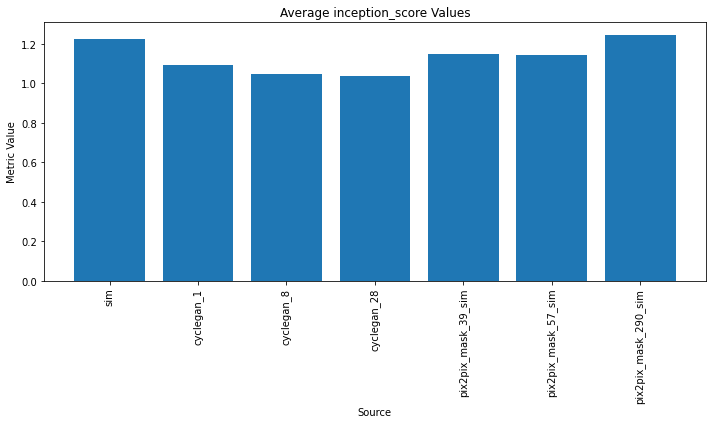

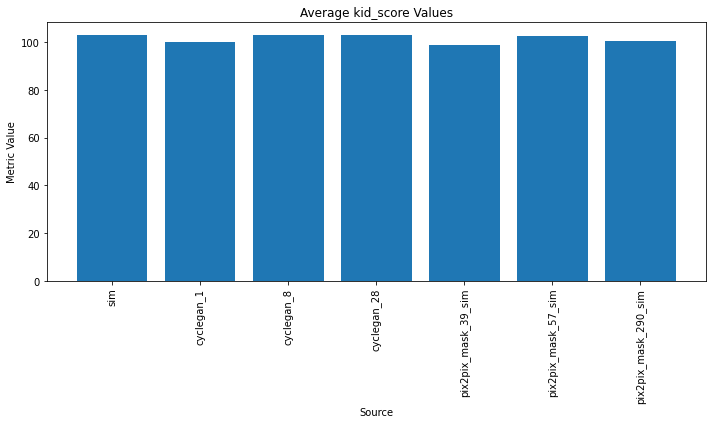

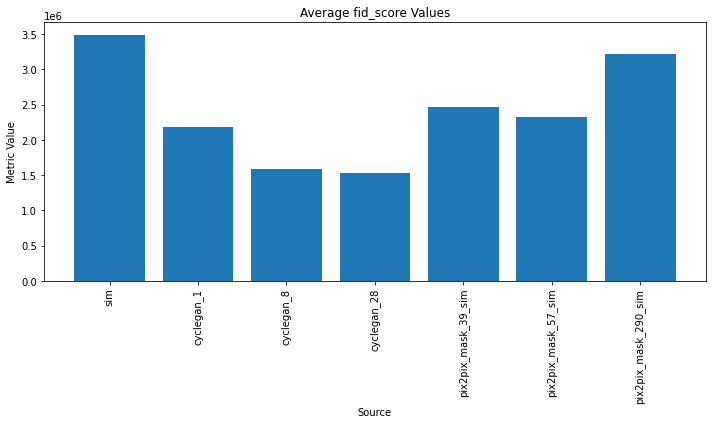

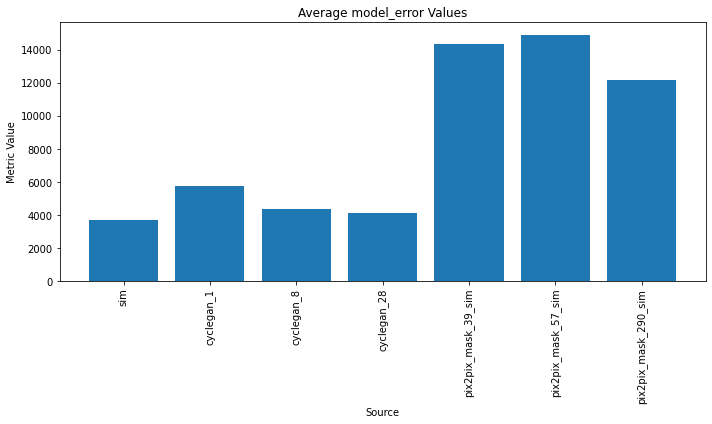

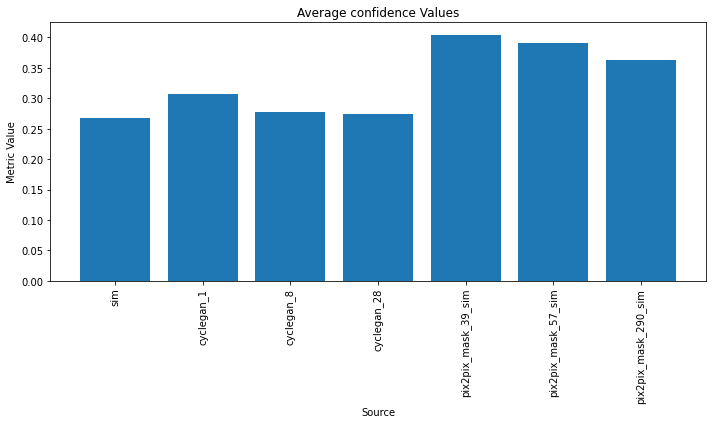

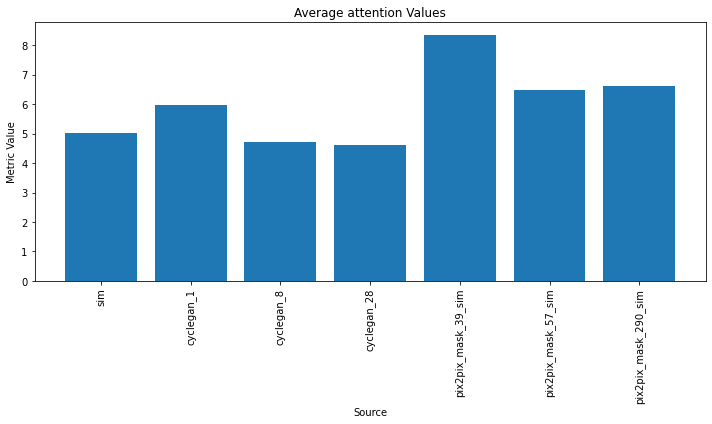

In [15]:
# Initialize dictionaries to store the average values for each metric
average_metrics = {
    'inception_score': {},
    'kid_score': {},
    'fid_score': {},
    'model_error': {},
    'confidence': {},
    'attention': {}
}

print(model_att_dict["sim__sim"])



# Iterate through image metrics and sources
for image_metric in image_metrics:
    if(image_metric=='inception_score' or image_metric=="kid_score" or image_metric=="fid_score"):
        for model_type, models in sources.items():
            for source_name in models:
                if source_name != 'real':
                    # Get the data for the current source and image metric
                    data = image_metrics_dict[model_type + "__" + source_name][image_metric]
        
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)
        
                    # Store the average value in the corresponding dictionary
                    average_metrics[image_metric][source_name] = average_value

                    data = model_loss_dict[model_type+"__"+source_name]
                    data=[abs(x-y) for x,y in zip(data,model_loss_dict["real__real"])]
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)

                    average_metrics["model_error"][source_name] = average_value

                    data = model_att_dict[model_type+"__"+source_name]
                    data=[abs(x-y) for x,y in zip(data,model_att_dict["real__real"])]
                    print(model_type+"__"+source_name)
        
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)

                    average_metrics["attention"][source_name] = average_value

                    data = model_conf_dict[model_type+"__"+source_name]
                    # data=[1-abs(x-y) for x,y in zip(data,model_conf_dict["real__real"])]
                    # if(type=='kitti'):
                    data=[1-abs(abs(a_i-b_i)-a_i) if b_i>0.5 else  1-abs(abs(a_i-0.5)-a_i) for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
                    # else:
                    #     data=[abs(a_i-b_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
            
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)

                    average_metrics["confidence"][source_name] = average_value

# Create a separate bar plot for each metric
for metric in average_metrics:
    source_names = list(average_metrics[metric].keys())
    average_values = list(average_metrics[metric].values())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(f"Average {metric} Values")
    ax.set_xlabel("Source")
    ax.set_ylabel("Metric Value")
    
    # Plot the average values as a bar plot
    x = np.arange(len(source_names))
    ax.bar(x, average_values, tick_label=source_names, align='center')
    
    # Customize the plot as needed (e.g., labels, legends, etc.)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Correlation between Model Error and inception_score: 0.41 significance 0.3620526216262729
Correlation between Model Error and kid_score: -0.54 significance 0.21221757238137096
Correlation between Model Error and fid_score: 0.24 significance 0.6035293568531935
Correlation between Conf and inception_score: 0.37 significance 0.41558911756851746
Correlation between Conf and kid_score: -0.64 significance 0.12158417327889873
Correlation between Conf and fid_score: 0.21 significance 0.6499583553055727
Correlation between Att Error and inception_score: 0.41 significance 0.35891171365503205
Correlation between Att Error and kid_score: -0.86 significance 0.012510987972506559
Correlation between Att Error and fid_score: 0.31 significance 0.5043546937373276


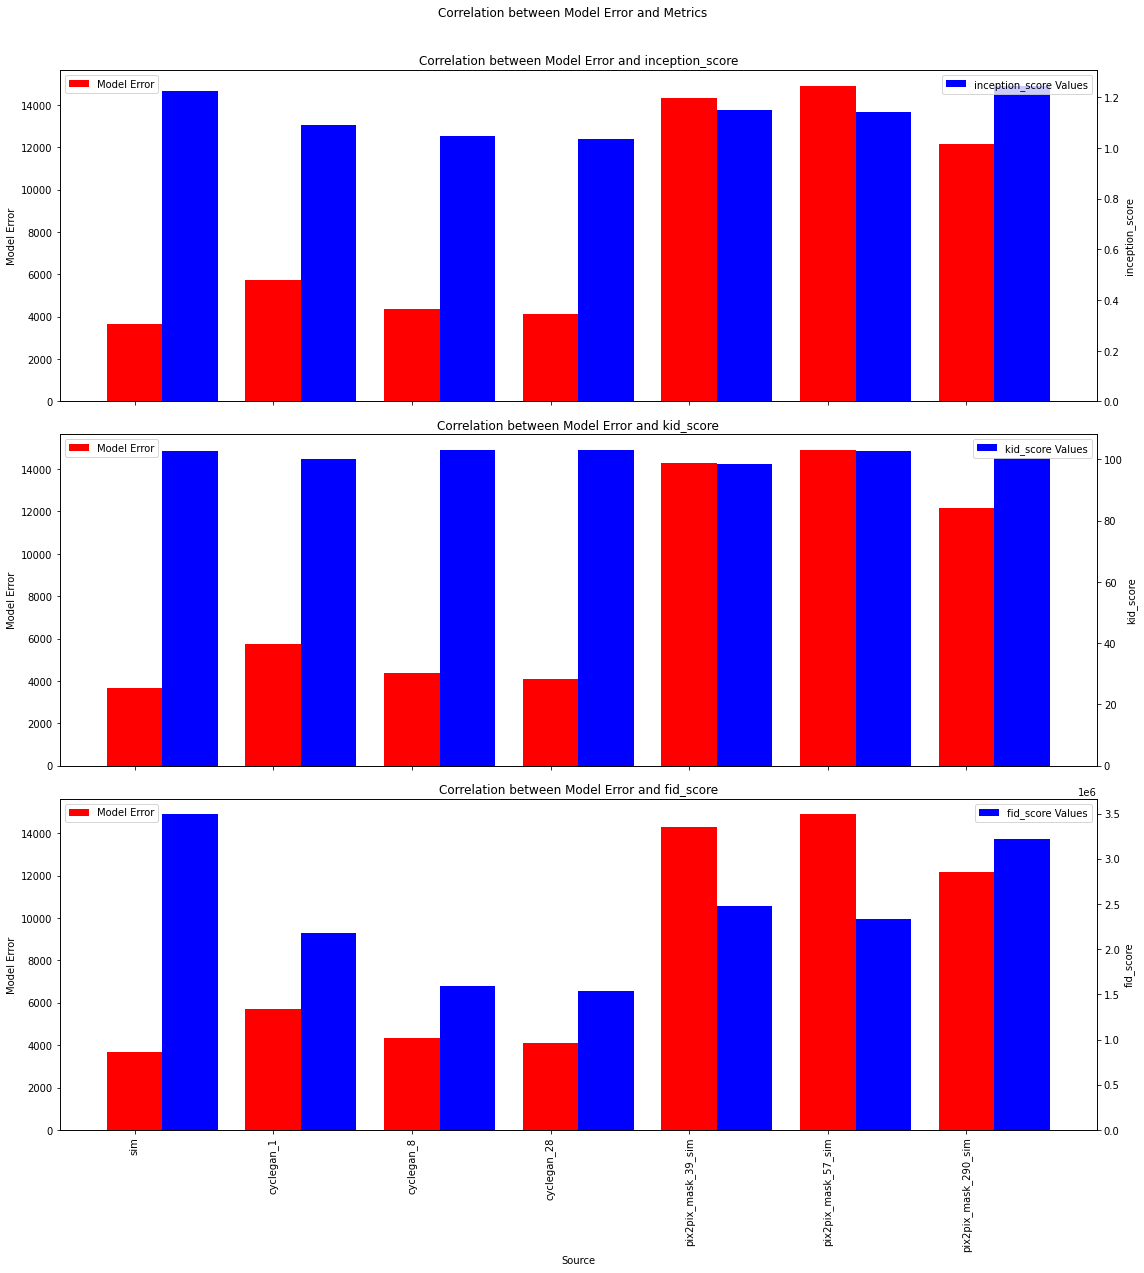

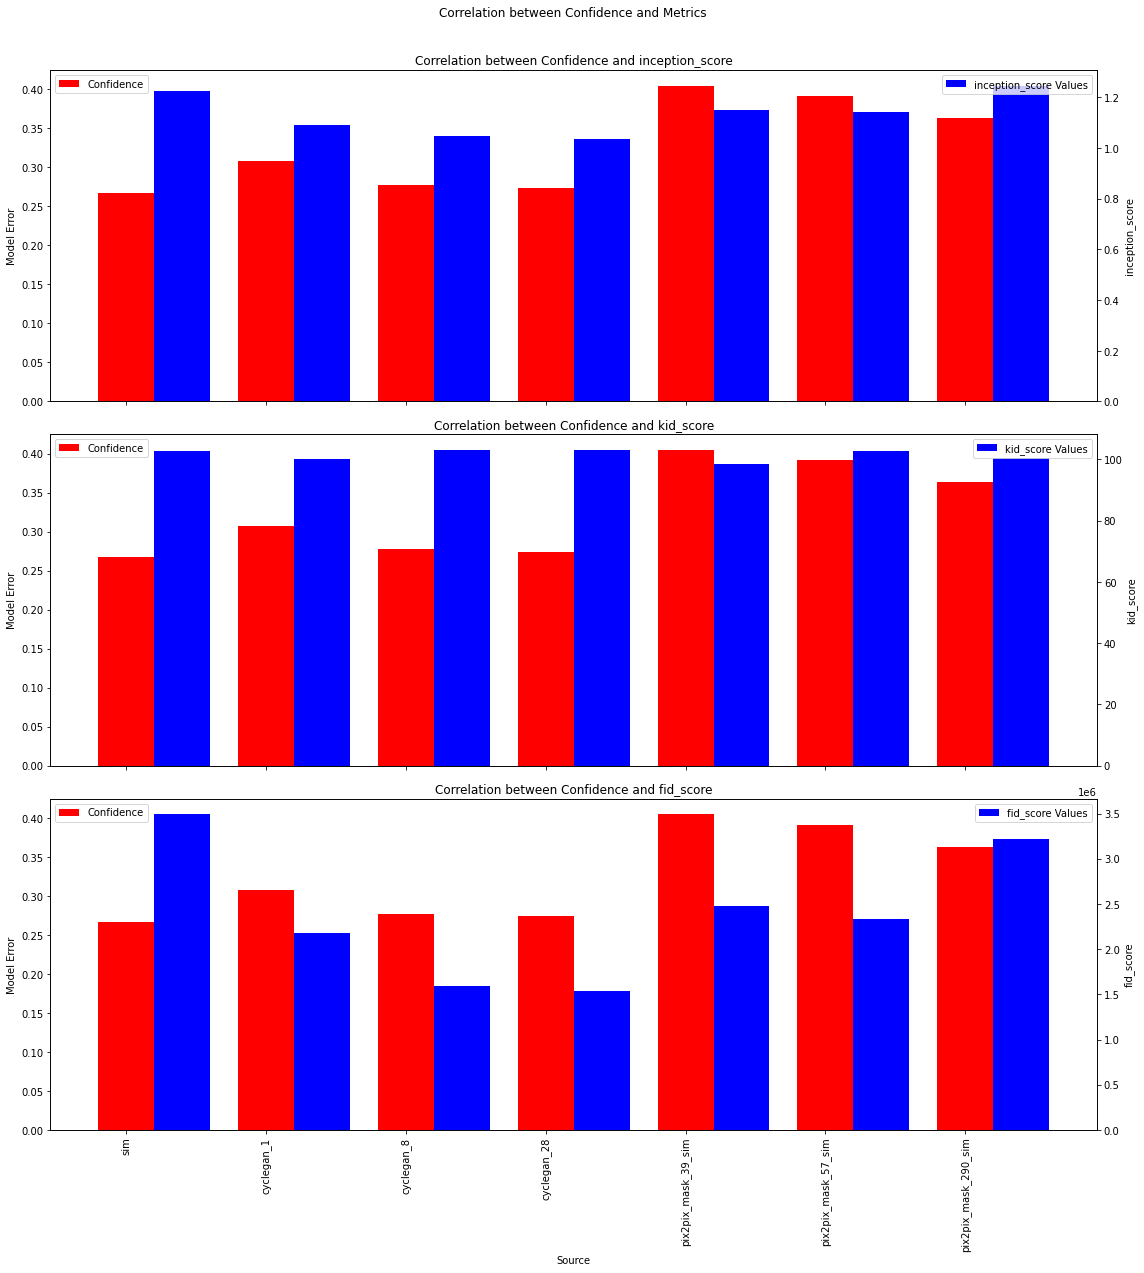

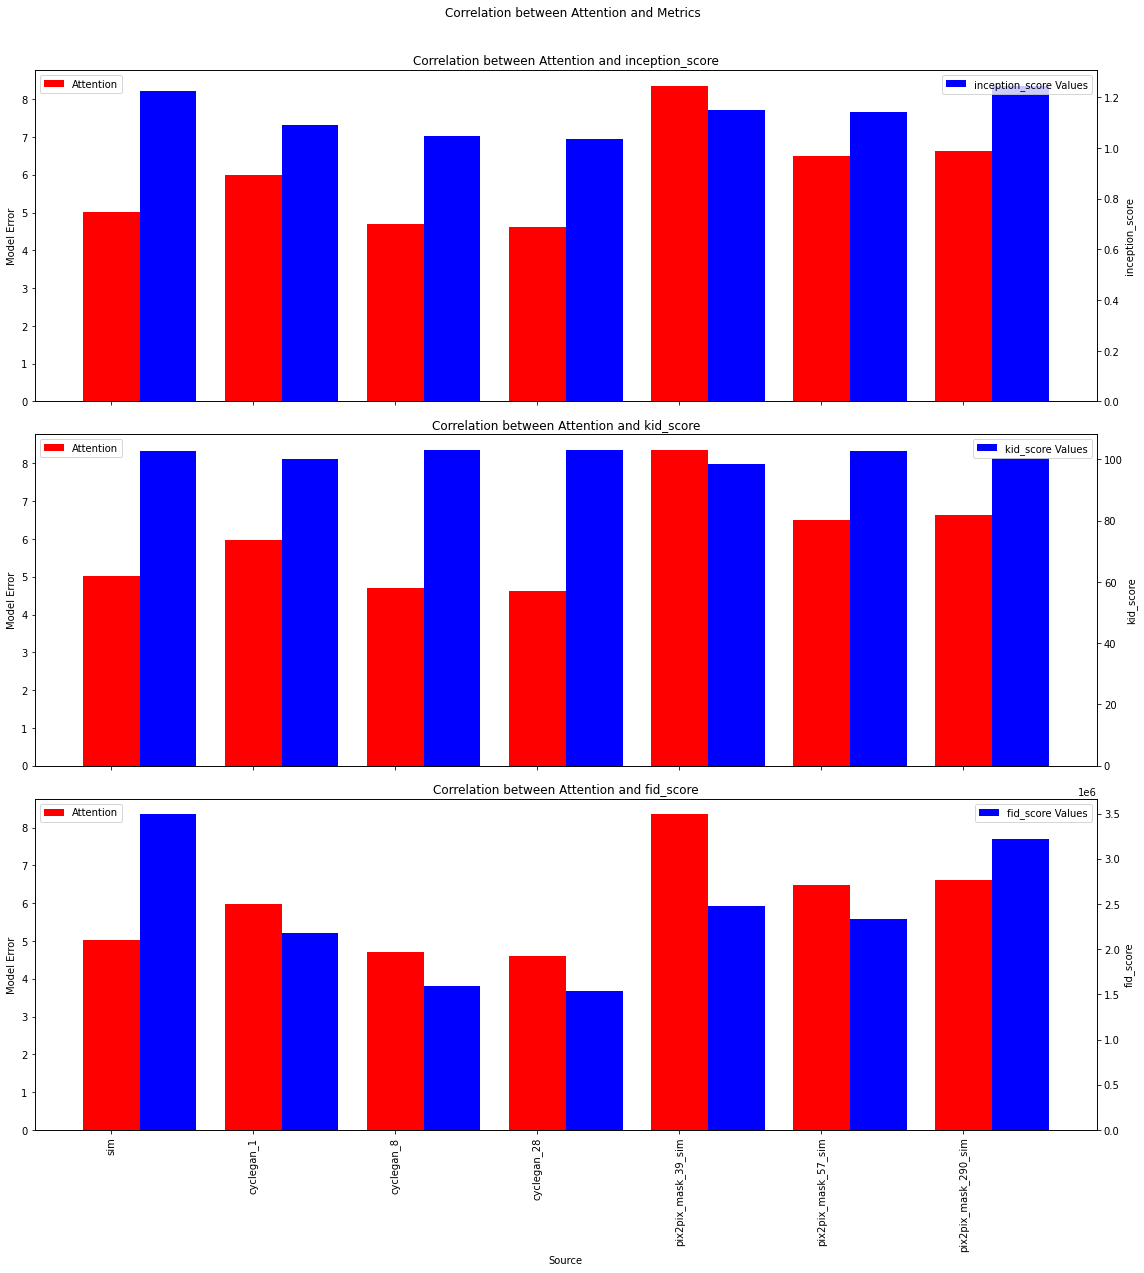

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Your existing code for calculating and plotting average metrics

# Create a common x-axis
source_names = list(average_metrics['inception_score'].keys())
x = np.arange(len(source_names))


for correlation_metric in ['inception_score','kid_score','fid_score']:
    model_errors = [average_metrics['model_error'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
    
    correlation, sign = pearsonr(model_errors, metric_values)
    
    print(f"Correlation between Model Error and {correlation_metric}: {correlation:.2f} significance {sign}")

for correlation_metric in ['inception_score','kid_score','fid_score']:
    model_errors = [average_metrics['confidence'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
    
    correlation, sign = pearsonr(model_errors, metric_values)
    
    print(f"Correlation between Conf and {correlation_metric}: {correlation:.2f} significance {sign}")

for correlation_metric in ['inception_score','kid_score','fid_score']:
    model_errors = [average_metrics['attention'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
    
    correlation, sign = pearsonr(model_errors, metric_values)
    
    print(f"Correlation between Att Error and {correlation_metric}: {correlation:.2f} significance {sign}")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)  # 3 rows, 1 column

# Loop through correlation metrics
for i, correlation_metric in enumerate(['inception_score', 'kid_score', 'fid_score']):
    model_errors = [average_metrics['model_error'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]

    correlation, _ = pearsonr(model_errors, metric_values)

    # Plot the correlation
    ax = axes[i]
    ax.bar(x, model_errors, width=0.4, label='Model Error', color='red')
    ax.set_ylabel('Model Error')

    # Create a twin axis for metric values
    ax2 = ax.twinx()
    ax2.bar(x + 0.4, metric_values, width=0.4, label=f'{correlation_metric} Values', color='blue')
    ax2.set_ylabel(f'{correlation_metric}')

    ax.set_title(f"Correlation between Model Error and {correlation_metric}")
    ax.set_xticks(x)
    ax.set_xticklabels(source_names, rotation=90)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Set a common title and x-axis label
fig.suptitle('Correlation between Model Error and Metrics')
axes[-1].set_xlabel("Source")

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the rect for the title
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)  # 3 rows, 1 column
for i, correlation_metric in enumerate(['inception_score', 'kid_score', 'fid_score']):
    model_errors = [average_metrics['confidence'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]

    correlation, _ = pearsonr(model_errors, metric_values)

    # Plot the correlation
    ax = axes[i]
    ax.bar(x, model_errors, width=0.4, label='Confidence', color='red')
    ax.set_ylabel('Model Error')

    # Create a twin axis for metric values
    ax2 = ax.twinx()
    ax2.bar(x + 0.4, metric_values, width=0.4, label=f'{correlation_metric} Values', color='blue')
    ax2.set_ylabel(f'{correlation_metric}')

    ax.set_title(f"Correlation between Confidence and {correlation_metric}")
    ax.set_xticks(x)
    ax.set_xticklabels(source_names, rotation=90)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Set a common title and x-axis label
fig.suptitle('Correlation between Confidence and Metrics')
axes[-1].set_xlabel("Source")

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the rect for the title
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)  # 3 rows, 1 column
for i, correlation_metric in enumerate(['inception_score', 'kid_score', 'fid_score']):
    model_errors = [average_metrics['attention'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]

    correlation, _ = pearsonr(model_errors, metric_values)

    # Plot the correlation
    ax = axes[i]
    ax.bar(x, model_errors, width=0.4, label='Attention', color='red')
    ax.set_ylabel('Model Error')

    # Create a twin axis for metric values
    ax2 = ax.twinx()
    ax2.bar(x + 0.4, metric_values, width=0.4, label=f'{correlation_metric} Values', color='blue')
    ax2.set_ylabel(f'{correlation_metric}')

    ax.set_title(f"Correlation between Attention and {correlation_metric}")
    ax.set_xticks(x)
    ax.set_xticklabels(source_names, rotation=90)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Set a common title and x-axis label
fig.suptitle('Correlation between Attention and Metrics')
axes[-1].set_xlabel("Source")

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the rect for the title
plt.show()


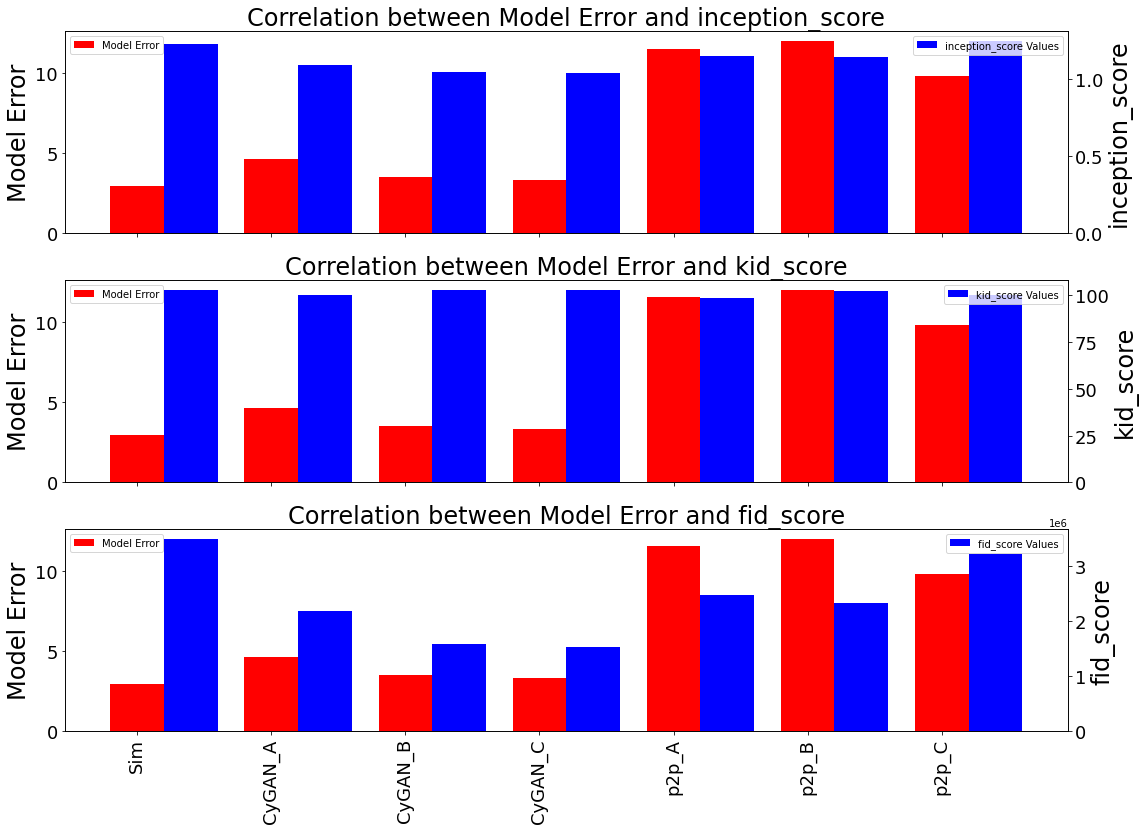

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Your existing code for calculating and plotting average metrics

# Create a common x-axis
source_names = list(average_metrics['inception_score'].keys())
x = np.arange(len(source_names))

source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
                     "p2p_A", "p2p_B", "p2p_C"]

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)  # 3 rows, 1 column

# Loop through correlation metrics
for i, correlation_metric in enumerate(['inception_score', 'kid_score', 'fid_score']):
    model_errors = [average_metrics['model_error'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]

    correlation, _ = pearsonr(model_errors, metric_values)

    # Plot the correlation\
    if type == "kitti":
            model_errors = [error / (1242) for error in model_errors]
    ax = axes[i]
    ax.bar(x, model_errors, width=0.4, label='Model Error', color='red')
    ax.set_ylabel('Model Error', fontsize=24)

    # Create a twin axis for metric values
    ax2 = ax.twinx()
    ax2.bar(x + 0.4, metric_values, width=0.4, label=f'{correlation_metric} Values', color='blue')
    ax2.set_ylabel(f'{correlation_metric}',fontsize=24)

    ax.set_title(f"Correlation between Model Error and {correlation_metric}", fontsize=24)
    ax.set_xticks(x)
    ax.set_xticklabels(source_names_plot, rotation=90)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.tick_params(axis='x', labelsize=18)
    ax2.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

# Set a common title and x-axis label

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the rect for the title
plt.savefig('merged_plot_dist_rq1.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/c_/y8w1xknx0636psltcpf92v21jbs3h7/T/ipykernel_83518/582929435.py:92: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  legend_ax=plt.subplot2grid((2,3), (1, 0), colspan=3)


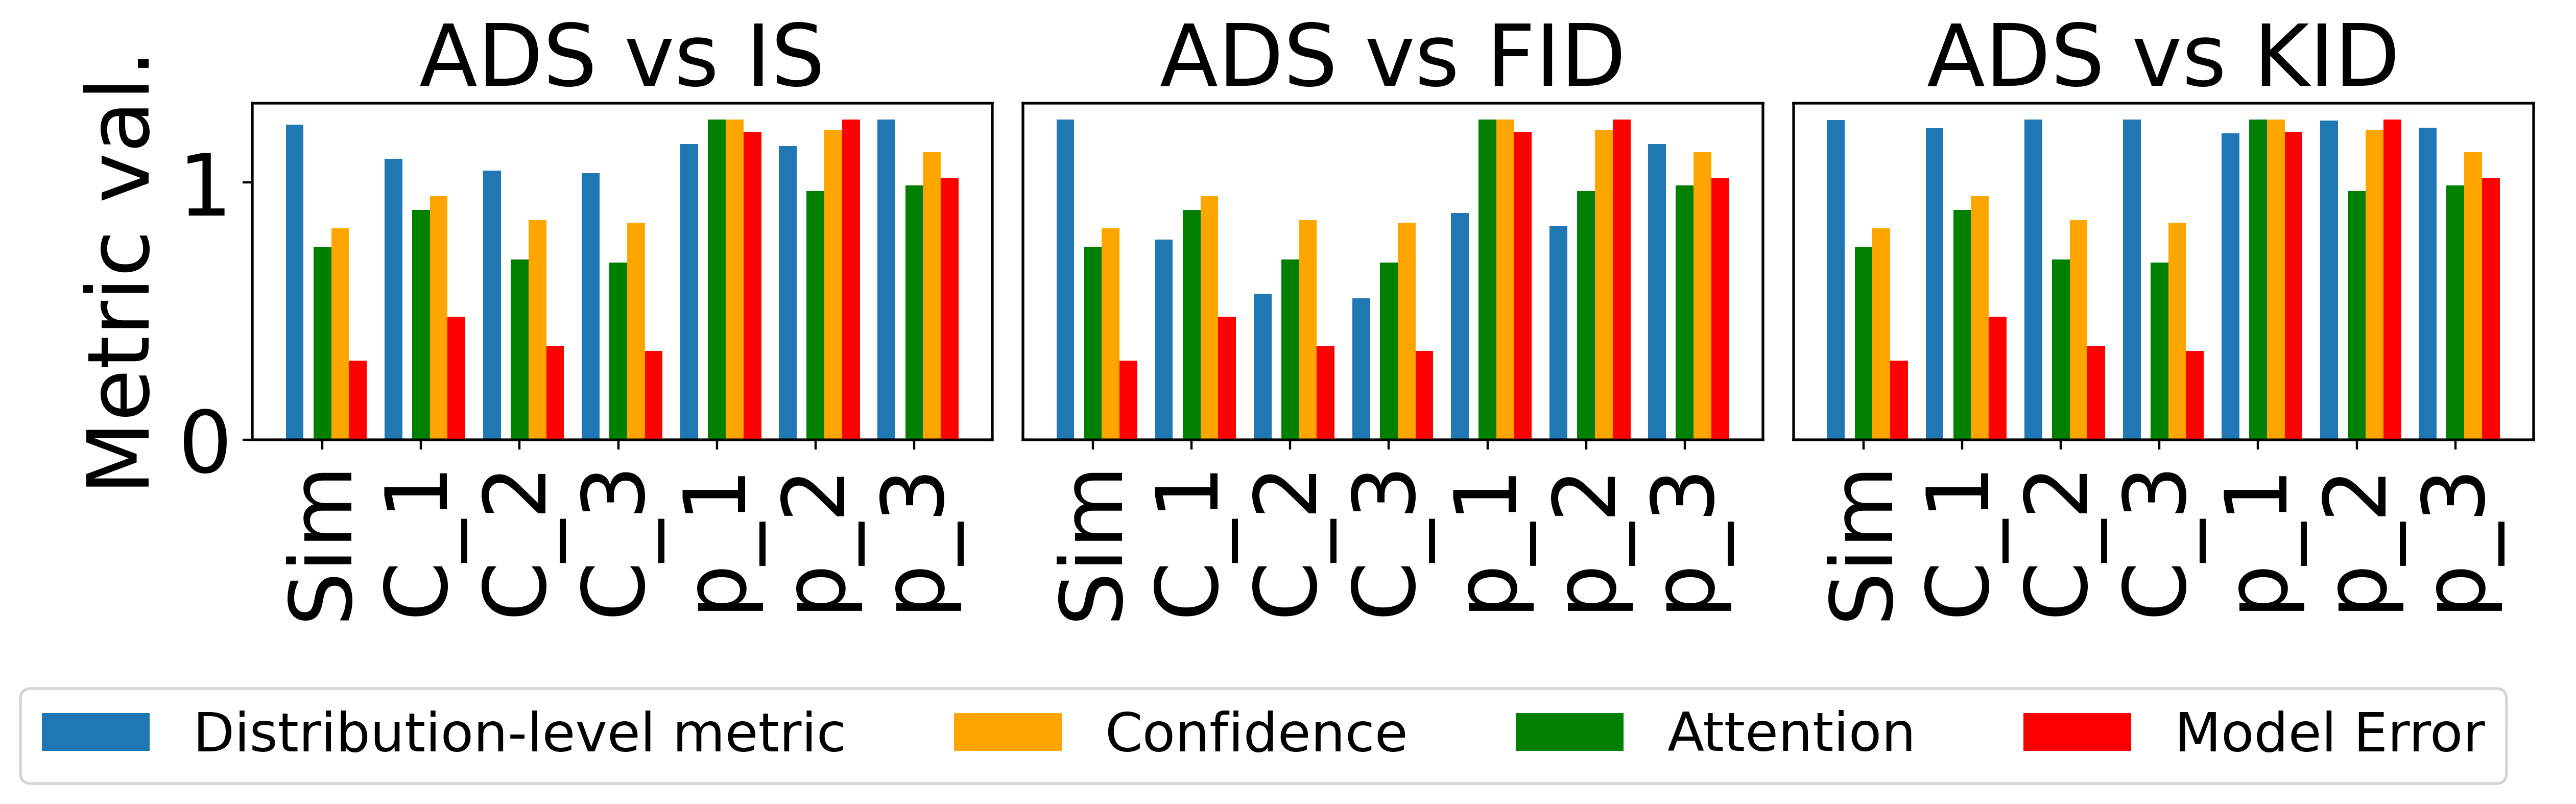

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.ticker import ScalarFormatter






# Create a common x-axis
source_names = list(average_metrics['inception_score'].keys())
x = np.arange(len(source_names))

# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
#                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]

source_names_plot = ["Sim", "C_1", "C_2", "C_3", 
                     "p_1", "p_2", "p_3"]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 5), sharex=False,dpi=400, gridspec_kw={'height_ratios': [5,1]})  

correlation_metrics = ['inception_score', 'fid_score', 'kid_score']



for i, correlation_metric in enumerate(correlation_metrics):
    # Get data for each metric
    model_errors = [average_metrics['model_error'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
    confidence_values = [average_metrics['confidence'][source_name] for source_name in source_names]
    attention_values = [average_metrics['attention'][source_name] for source_name in source_names]

    if type == "kitti":
        model_errors = [error / (1242) for error in model_errors]

    # Calculate the bar width and positions
    bar_width = 0.18
    x_positions_metric = x - bar_width-0.1
    x_positions_attention = x
    x_positions_confidence = x + bar_width
    x_positions = x + bar_width*2

    # Plot the bars for model error
    ax = axes[0,i]
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()
    a=ax4.bar(x_positions, model_errors, width=bar_width, label='Model Error', color='red')
    b=ax2.bar(x_positions_confidence, confidence_values, width=bar_width, label='Confidence', color='orange')
    c=ax3.bar(x_positions_attention, attention_values, width=bar_width, label='Attention', color='green')
    d=ax.bar(x_positions_metric, metric_values, width=bar_width, label='Distribution-level metric')

    ax2.tick_params(axis='x', labelsize=30)
    ax2.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax3.tick_params(axis='x', labelsize=30)
    ax3.tick_params(axis='y', labelsize=30)
    ax4.tick_params(axis='x', labelsize=30)
    ax4.tick_params(axis='y', labelsize=30)

    
    if i==0:
        ax.set_ylabel('Metric val.', fontsize=30)
        ax.set_title(f"ADS vs IS", fontsize=30)
    elif i==1:
        ax.set_title(f"ADS vs FID", fontsize=30)
    else:
        ax.set_title(f"ADS vs KID", fontsize=30)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    # if i==0:
    #     ax4.legend(lines+lines2+lines3+lines4, labels+labels2+labels3+labels4, ncol=2, fontsize=30)
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax4.set_yticklabels([])
    ax2.yaxis.set_ticks([])
    ax3.yaxis.set_ticks([])
    ax4.yaxis.set_ticks([])
    if i!=0:
        ax.set_yticks([])
    ax.set_xticks(x)
    ax.set_xticklabels(source_names_plot, rotation=90, fontsize=30)
    
    
# Set a common title and x-axis label
legend_ax=plt.subplot2grid((2,3), (1, 0), colspan=3)
legend_ax.spines['top'].set_visible(False)
legend_ax.spines['right'].set_visible(False)
legend_ax.spines['bottom'].set_visible(False)
legend_ax.spines['left'].set_visible(False)
legend_ax.tick_params(labelcolor="none", bottom=False, left=False)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
legend_ax.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, ncol=4, fontsize=19)

# Set a common title and x-axis label
plt.tight_layout(rect=[0, 0, 0.8, 0.8])  # Adjust the rect for the title
plt.savefig('merged_plot_dist_rq2.png', dpi=400, bbox_inches='tight')
plt.show()

plots for dataset:  *
{'sim': ['sim'], 'real': ['real'], 'cyclegan': ['cyclegan_1', 'cyclegan_8', 'cyclegan_28'], 'pix2pix_mask_manual': ['pix2pix_mask_39_sim', 'pix2pix_mask_57_sim', 'pix2pix_mask_290_sim']}
1063
{'sim__sim': {'sim_real': [], 'sim': [], 'real': [], 'additional': []}, 'real__real': {}, 'cyclegan__cyclegan_1': {'sim_real': [], 'sim': [], 'real': [], 'additional': []}, 'cyclegan__cyclegan_8': {'sim_real': [], 'sim': [], 'real': [], 'additional': []}, 'cyclegan__cyclegan_28': {'sim_real': [], 'sim': [], 'real': [], 'additional': []}, 'pix2pix_mask_manual__pix2pix_mask_39_sim': {'sim_real': [], 'sim': [], 'real': [], 'additional': []}, 'pix2pix_mask_manual__pix2pix_mask_57_sim': {'sim_real': [], 'sim': [], 'real': [], 'additional': []}, 'pix2pix_mask_manual__pix2pix_mask_290_sim': {'sim_real': [], 'sim': [], 'real': [], 'additional': []}}
new: 0.13518440126821768 todo: inf
new: 0.39296173749276475 todo: 0.40643871001183557
new: 0.3093008388551485 todo: 0.3205921228823443
n

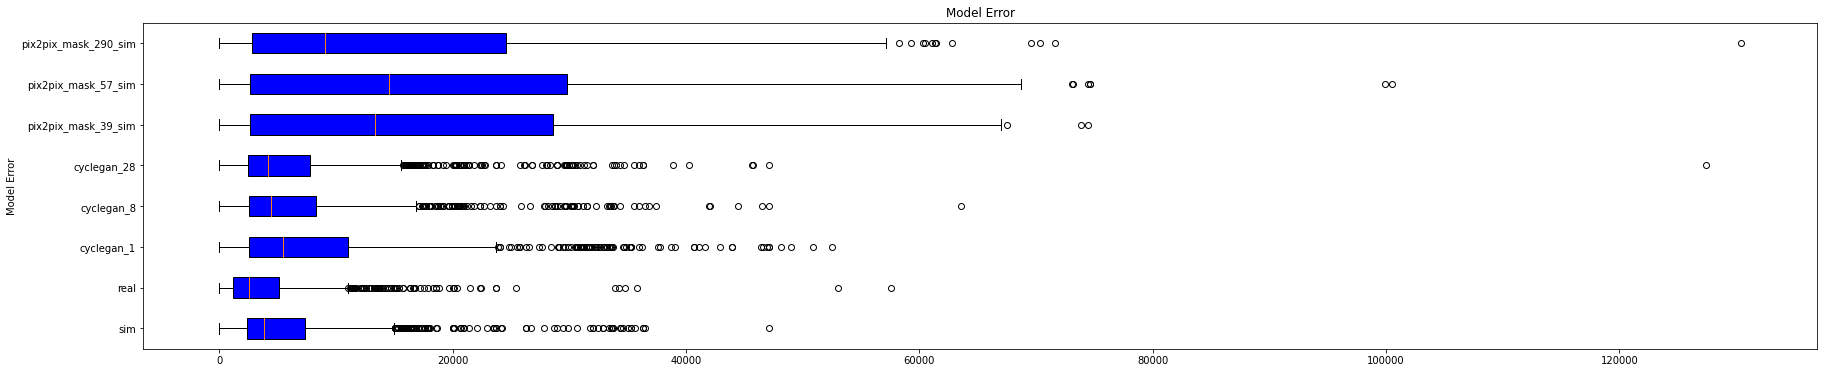

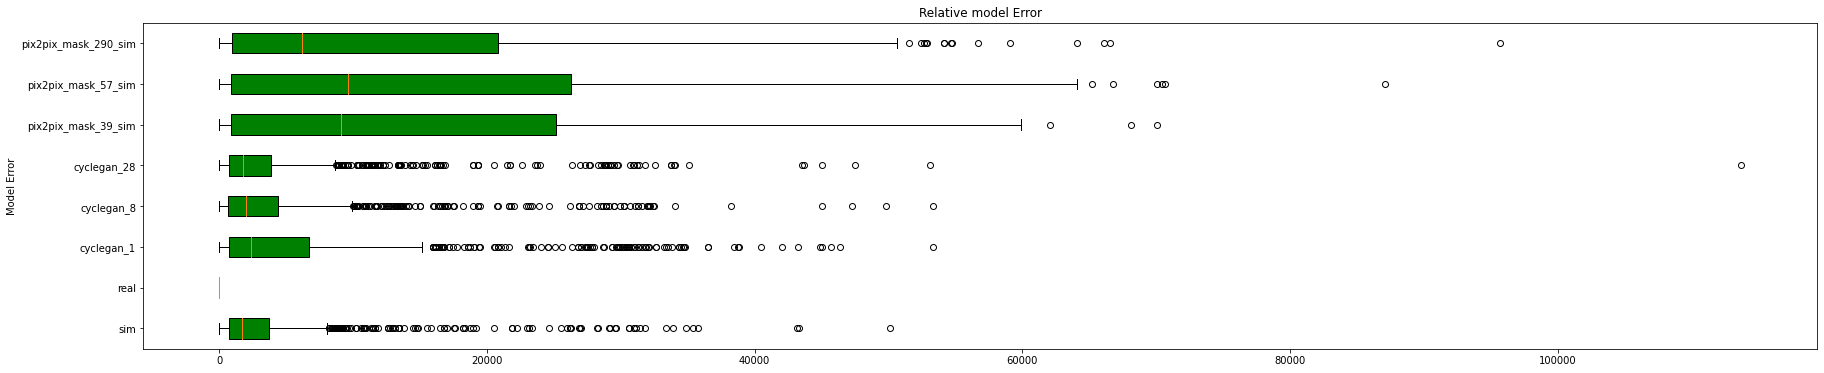

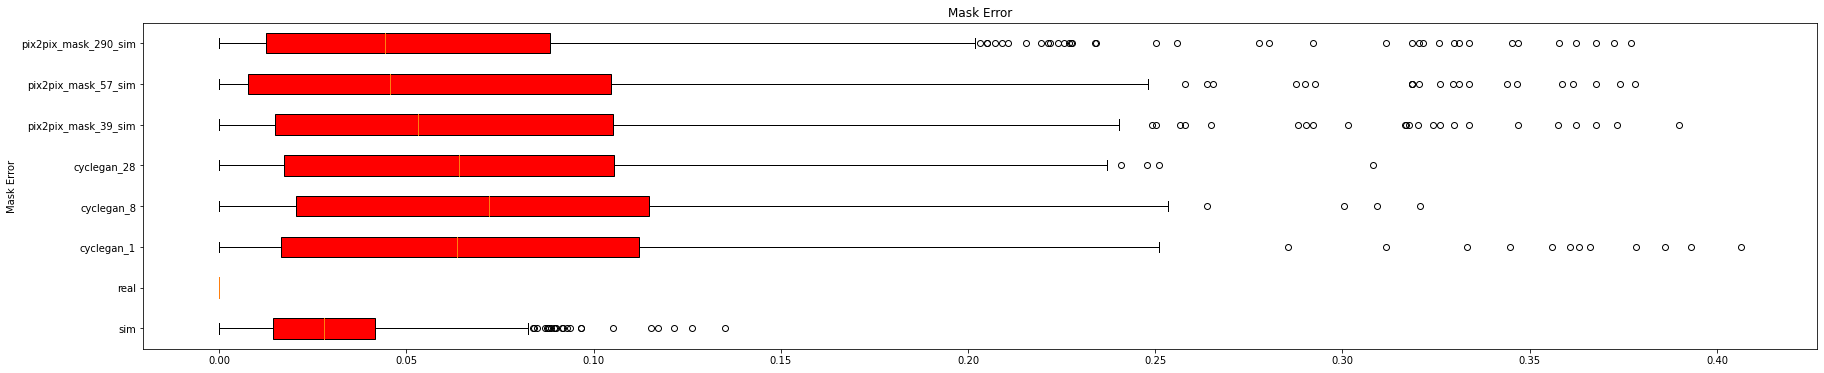

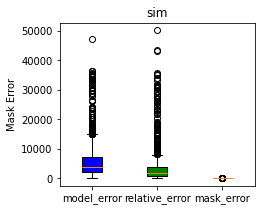

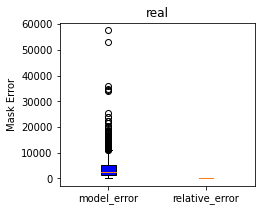

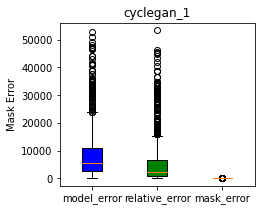

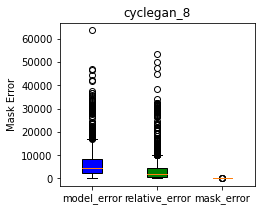

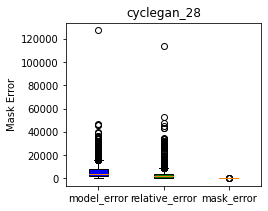

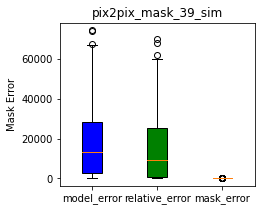

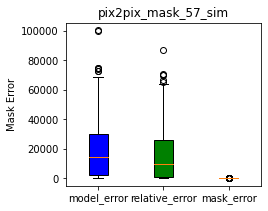

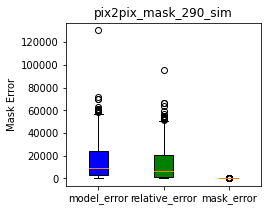

mask_error -0.022725990412831222
confidence 0.23834921241087398
attention 0.2229783385787448
ssim_scores 0.132650431448244
psnr_scores 0.18452854212192188
mse_scores -0.1839117483892356
cosine_similarities 0.008891452170491075
corr_coeffs 0.1412946004589675
text_sim -0.027711573999474166
wd_score 0.10125710920713693
kl_div 0.04873368347647274
hist_inter 0.15466697116550968
perc_dist 0.14826425207089905
inception_score nan
kde_scores 0.024675822326269192
kde_probs nan
ss_score 0.09805134476245526


/Users/lambertenghi/miniconda3/envs/tfEnv4/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


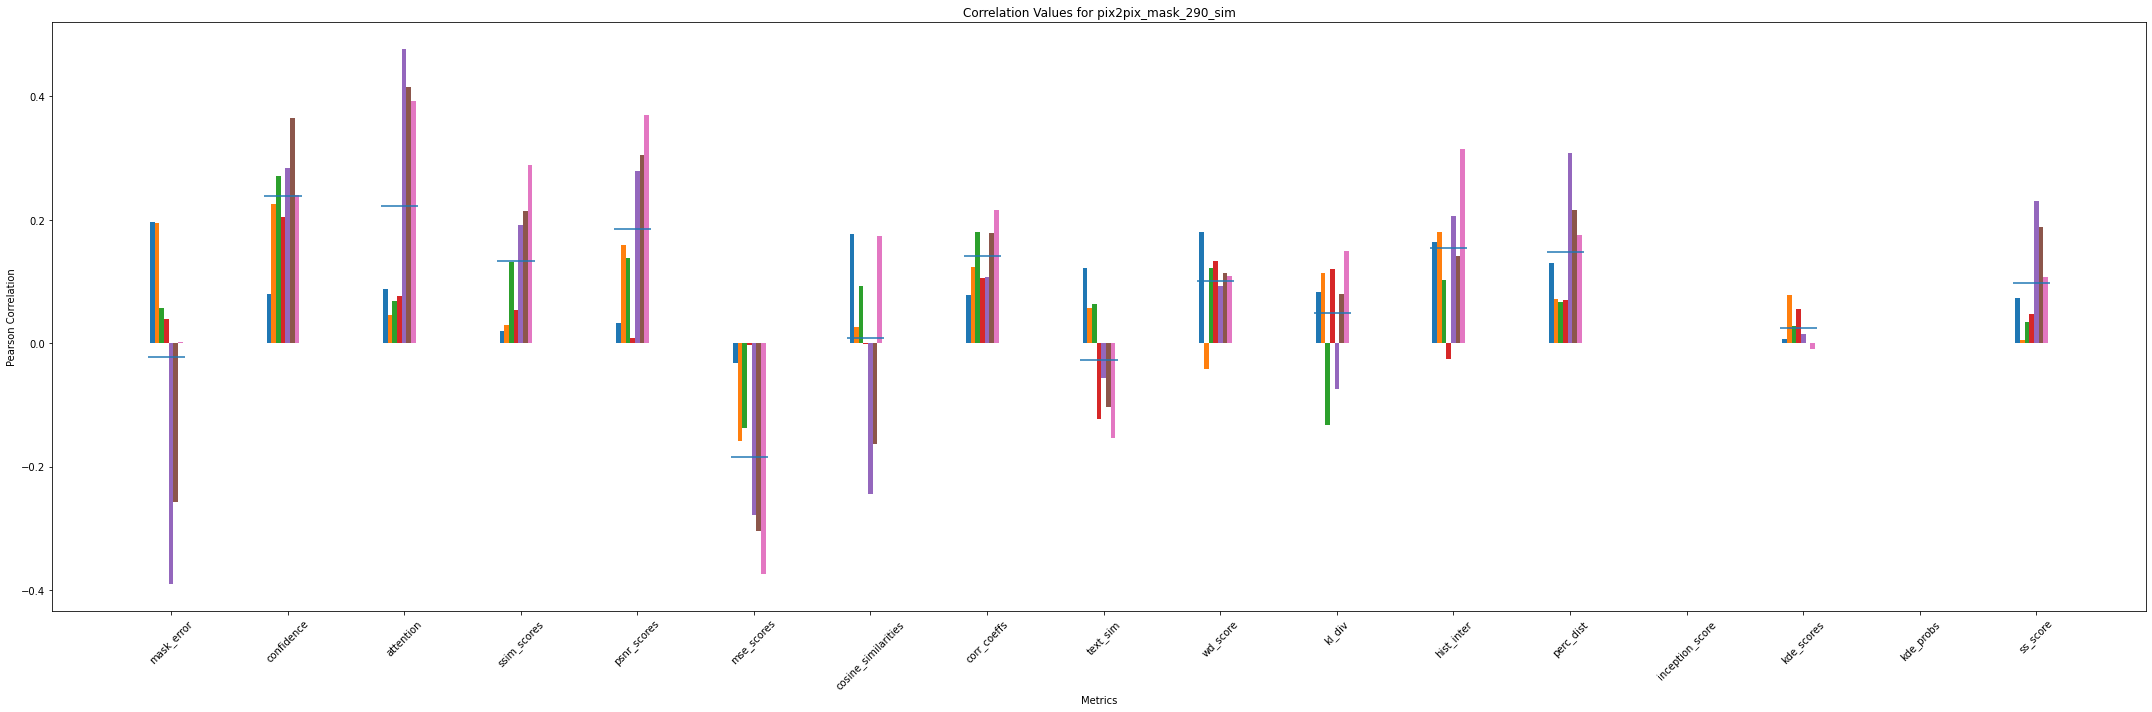

mask_error 0.0564489511327681
confidence 0.30262131546354026
attention 0.23742319250871471
ssim_scores 0.08669035057286999
psnr_scores 0.07852741384055471
mse_scores -0.07869258815309162
cosine_similarities 0.16351009158717714
corr_coeffs 0.1345378986304066
text_sim 0.006852363312090122
wd_score 0.08969623574529507
kl_div 0.09437871322484948
hist_inter 0.06237134005607355
perc_dist 0.06859727736784951
inception_score nan
kde_scores 0.012571024124151007
kde_probs nan
ss_score 0.08163030257396585


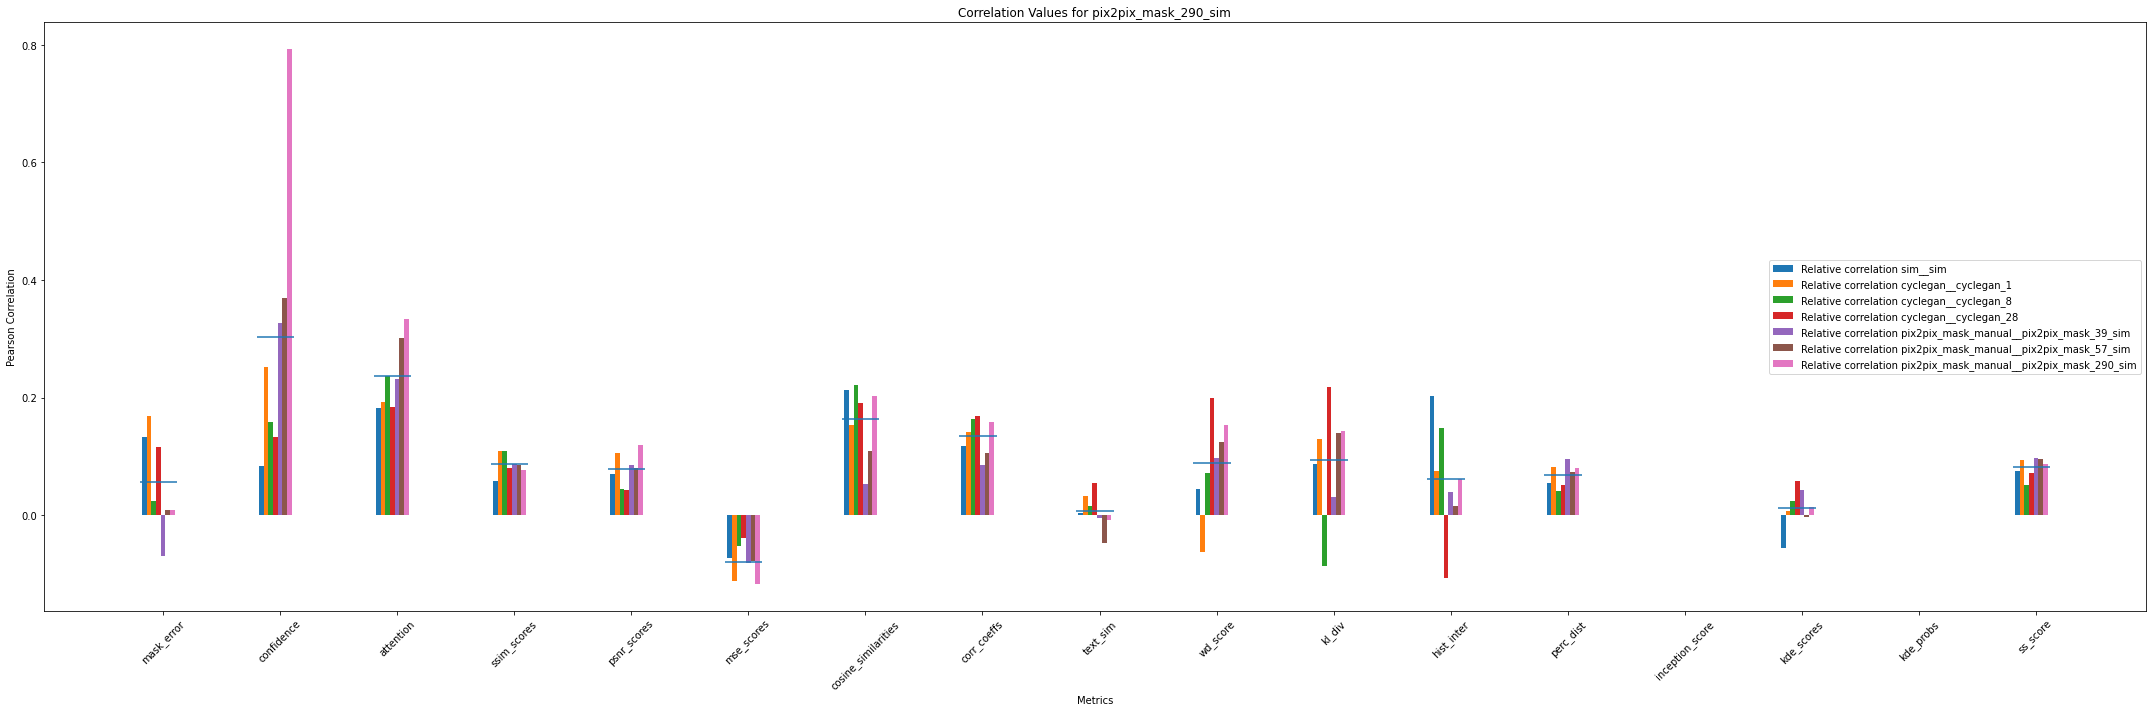

/var/folders/c_/y8w1xknx0636psltcpf92v21jbs3h7/T/ipykernel_83518/4089300103.py:345: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Model Error'])


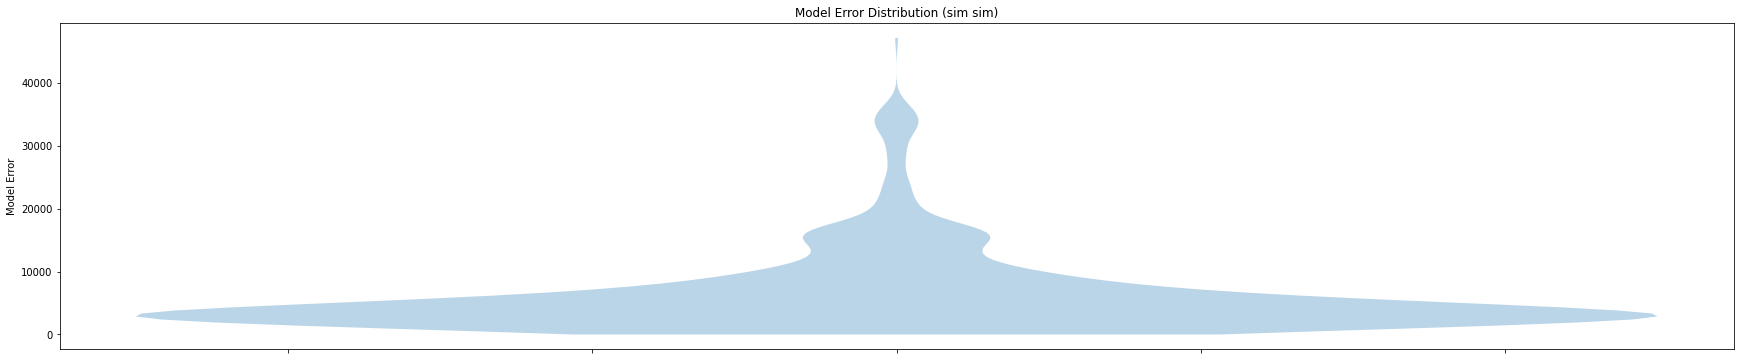

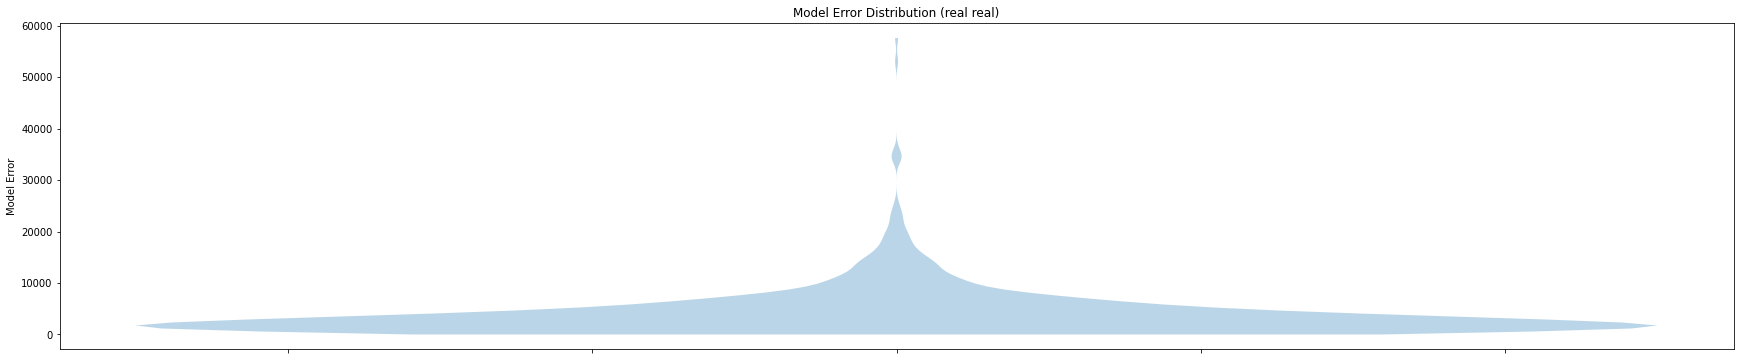

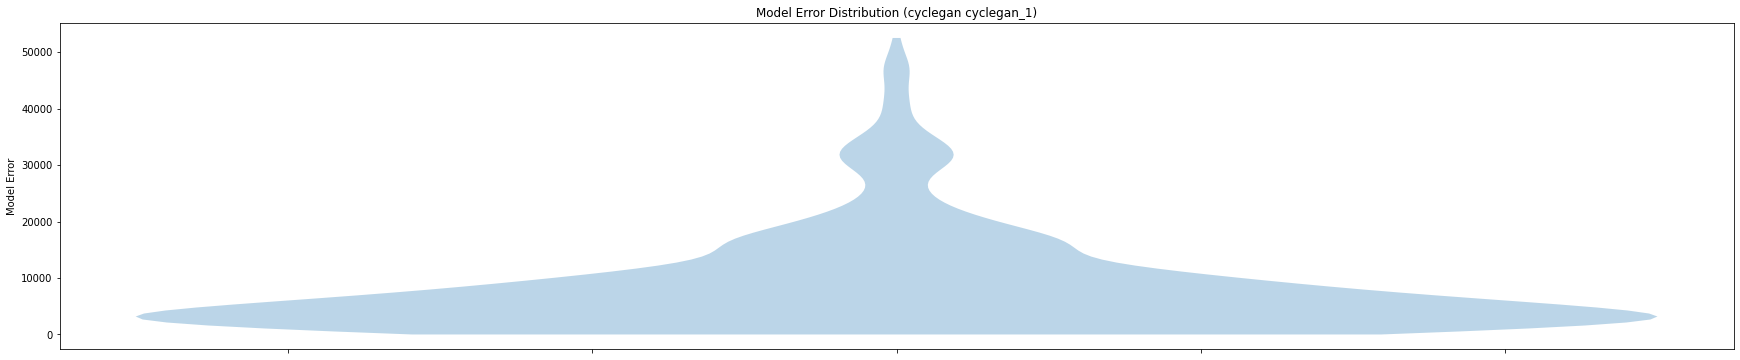

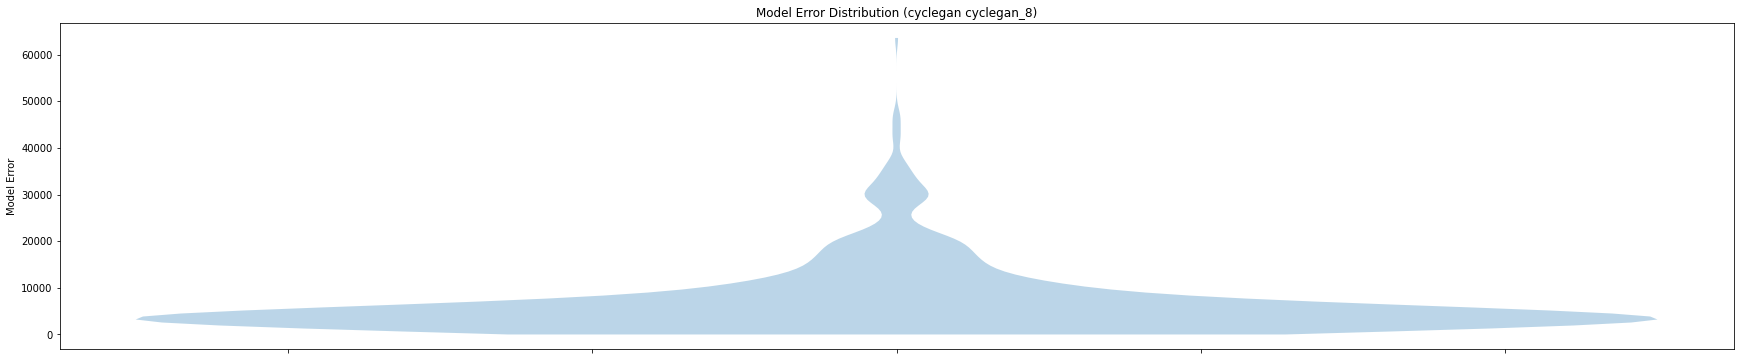

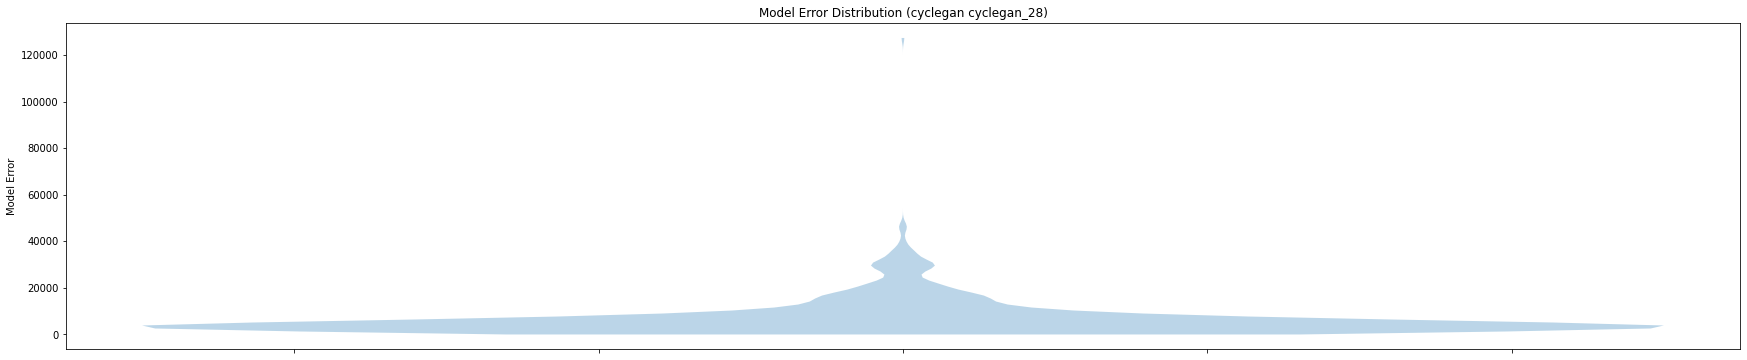

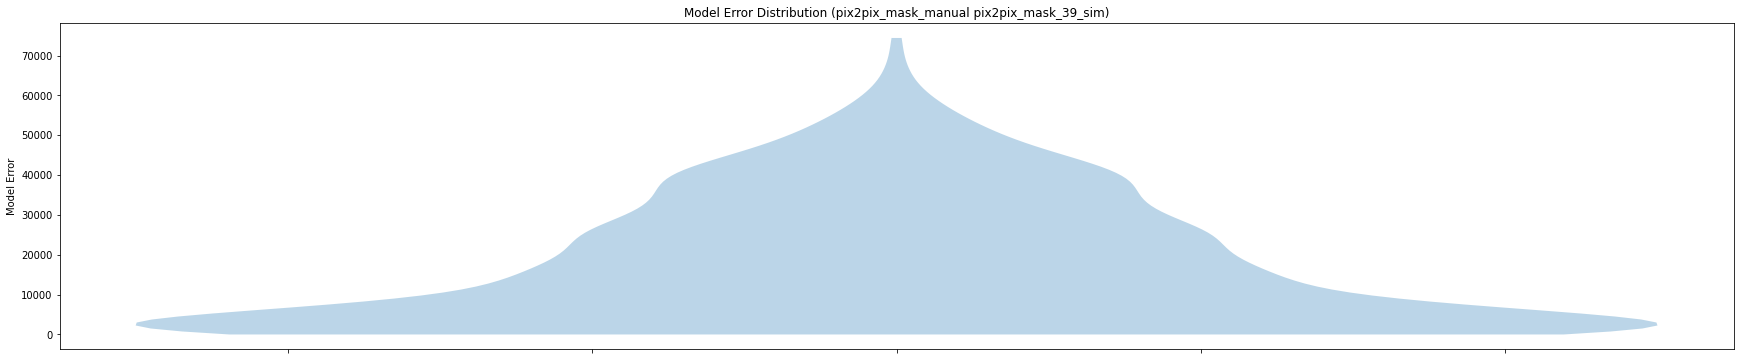

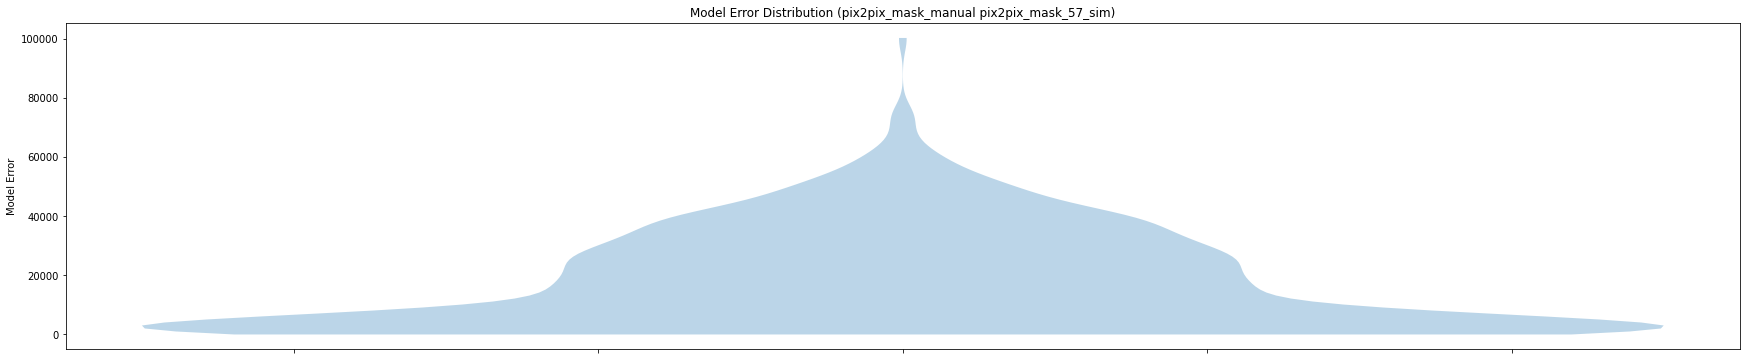

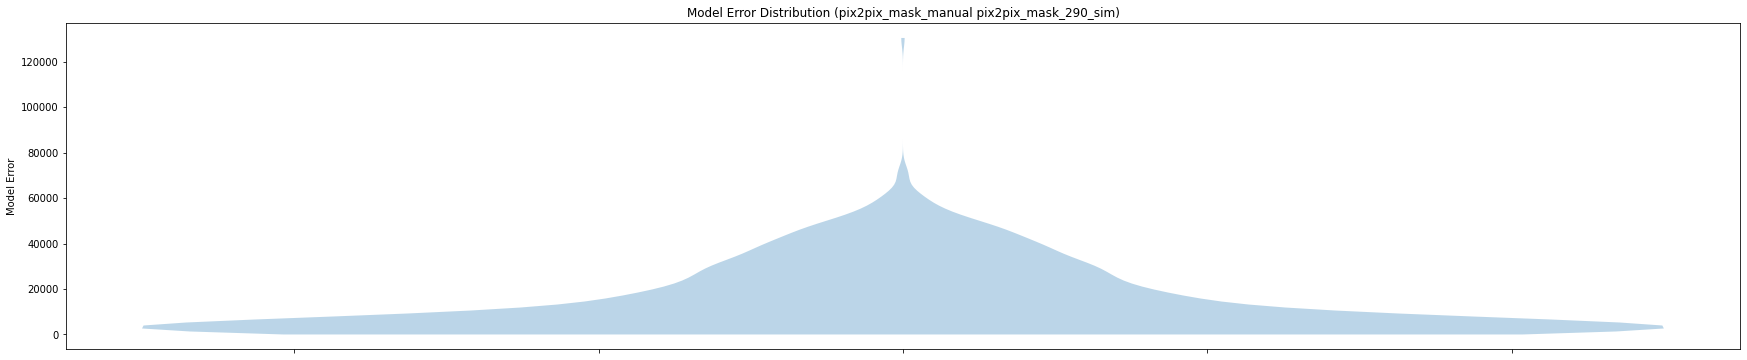

In [19]:
for dataset_id in dataset_ids:
    print("plots for dataset: ",dataset_id)
    print(sources)
    data_list=sorted(glob.glob(data_directory+'cyclegan/'+sources['cyclegan'][0]+'/'+dataset_id+'_*.png'),key=natural_sort_key)
    filenames=[]
    for path in data_list:
        filenames.append(path.split("/")[-1].split(".")[0])
    print(len(filenames))
    
    image_metrics=[]
    with open(image_metrics_path_dict['cyclegan__'+sources['cyclegan'][0]]+filenames[0]+".json", "r") as json_file:
                    error_data = json.load(json_file)
                    for key, value in error_data.items():
                        image_metrics.append(key)
    mask_errors=[]
    with open(mask_error_path_dict['cyclegan__'+sources['cyclegan'][0]]+filenames[0]+".json", "r") as json_file:
                    error_data = json.load(json_file)
                    for key, value in error_data.items():
                        mask_errors.append(key)
                        
    model_loss_dict={}
    model_conf_dict={}
    image_metrics_dict={}
    mask_error_dict={}
    model_att_dict={}
    for model_type, models in sources.items():
        for source_name in models:
            model_loss_dict[model_type+"__"+source_name]=[]
            model_conf_dict[model_type+"__"+source_name]=[]
            model_att_dict[model_type+"__"+source_name]=[]
            image_metrics_dict[model_type+"__"+source_name]={}
            mask_error_dict[model_type+"__"+source_name]={}
            for image_metric in image_metrics:
                image_metrics_dict[model_type+"__"+source_name][image_metric]=[]
            if(source_name!='real'):
                for mask_error in mask_errors:
                    mask_error_dict[model_type+"__"+source_name][mask_error]=[]
    print(mask_error_dict)
    
    for file in filenames:
        for model_type, models in sources.items():
            for source_name in models:
                    if(source_name!='real'):
                        with open(mask_error_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
                            error_data = json.load(json_file)
                            for key, value in error_data.items():
                                        if source_name=='sim' and key=='sim_real':
                                            mask_error_dict[model_type+"__"+source_name][key].append(float(value))
                                            mask_error_dict[model_type+"__"+source_name]['real'].append(float(value))
                                        else:
                                            mask_error_dict[model_type+"__"+source_name][key].append(float(value))
                    
                
                        with open(image_metrics_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
                            error_data = json.load(json_file)
                            
                            for metric_name, value in error_data.items():
                                        if metric_name=='perceptual_distances':
                                            print(source_name,metric_name,float(value))
                                        elif (metric_name == 'inception_mean_score' or metric_name == 'inception_std_score' or metric_name=="kid_score" or metric_name=="fid_score"):
                                            # print(file,metric_name,value)    
                                            image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
                                        else:
                                            image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
                    # if type=="kitti":
                    f = open(model_loss_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_loss=float(f.read())
                    model_loss_dict[model_type+"__"+source_name].append(model_loss)


                    f = open(model_conf_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_conf=float(f.read())
                    model_conf_dict[model_type+"__"+source_name].append(model_conf)

                    f = open(model_att_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_att=float(f.read())
                    model_att_dict[model_type+"__"+source_name].append(model_att)
                    # else:
                    #     print("TODO!!!")
    
    correlation_dict={}
    relative_correlation_dict={}

    
    y_min_model = min(np.min(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    y_max_model = max(np.max(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    y_max_mask=0
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                            
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            print("new:",max(new_list),"todo:",max(mask_error))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            y_max_mask=max(max(mask_error),y_max_mask)
    
    
    y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    for model_type, models in sources.items():
            for source_name in models:
                correlation_dict[model_type+"__"+source_name]={}
                relative_correlation_dict[model_type+"__"+source_name]={}
                if(source_name!='real'):
                            


                            if source_name!="sim":
                                mask_error = [abs(a - b) for a, b in zip(mask_error_dict[model_type+"__"+source_name]["real"], mask_error_dict[model_type+"__"+source_name]["sim_real"])]
                            else:
                                mask_error = mask_error_dict[model_type+"__"+source_name]["additional"]
        
                            # new_list = set(mask_error)
                            # new_list.remove(max(new_list))
                            print("new:",max(new_list),"todo:",max(mask_error))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            print(max(mask_error))
                            
                            pears=pearsonr(model_loss_dict[model_type+"__"+source_name], mask_error)
                            print(pears)
                            print(source_name,"model loss",np.mean(model_loss_dict[model_type+"__"+source_name]))
                            print(model_type,source_name,"mask loss",np.mean(mask_error))
                            # if type=="kitti":
    
                            pears_rel=pearsonr(relative_loss, mask_error)
                            
                            correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
                            relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel

                            pears=pearsonr(model_loss_dict[model_type+"__"+source_name], model_conf_dict[model_type+"__"+source_name])
                            print(pears)
                            print(source_name,"conf loss",np.mean(model_loss_dict[model_type+"__"+source_name]))
                            # if type=="kitti":
    
                            pears_rel=pearsonr(relative_loss,model_conf_dict[model_type+"__"+source_name])
                    

                            correlation_dict[model_type+"__"+source_name]["confidence"]=pears
                            relative_correlation_dict[model_type+"__"+source_name]["confidence"]=pears_rel
                    

                            pears=pearsonr(model_loss_dict[model_type+"__"+source_name], model_att_dict[model_type+"__"+source_name])
                            print(pears)
                            print(source_name,"att loss",np.mean(model_att_dict[model_type+"__"+source_name]))
                            # if type=="kitti":
    
                            pears_rel=pearsonr(relative_loss,model_att_dict[model_type+"__"+source_name])
                    

                            correlation_dict[model_type+"__"+source_name]["attention"]=pears
                            relative_correlation_dict[model_type+"__"+source_name]["attention"]=pears_rel
                
                            for image_metric in image_metrics:
                                if(image_metric!="perceptual_distances" and image_metric!="inception_mean_score" and image_metric!="inception_std_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
                                # and image_metric!="inception_mean_score" and image_metric!="inception_std_score" and image_metric!="fid_score" and image_metric!="kde_scores" and image_metric!="kde_probs"  and image_metric!="kid_score"):
                                    
                                    print(image_metric)
                                    metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]

                                    metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
                                    metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
                                    print(len(model_loss_dict[model_type+"__"+source_name]),len(metric_vals))
                                    pears=pearsonr(model_loss_dict[model_type+"__"+source_name], metric_vals)
                                    print(pears)
                                    correlation_dict[model_type+"__"+source_name][image_metric]=pears
                                    pears_rel=pearsonr(relative_loss, metric_vals)
                                    relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel
                                    print(model_type,source_name,image_metric,np.mean(image_metrics_dict[model_type+"__"+source_name][image_metric]))
                                else:
                                    print("VAL!")    
    
    # Define your min_max_normalize function here

     
    all_model_errors = []
    relative_model_errors = []
    all_mask_errors = []
    
    for model_type, models in sources.items():
        for source_name in models:
                # Create a list of model errors (you can modify this depending on your data structure)
            model_errors = model_loss_dict[model_type + "__" + source_name]
            if model_type!='real':
                mask_errors = mask_error_dict[model_type+"__"+source_name]["additional"]
            else:
                mask_errors = [0 for i in range(0, len(model_loss_dict[model_type+"__"+source_name]))]
            # Append the model errors to the list
            all_model_errors.append(model_errors)
            all_mask_errors.append(mask_errors)
            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
            # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
            relative_model_errors.append(relative_loss)
    
    # Create a single box plot for all sources
    fig, ax1 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
    fig, ax2 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
    fig, ax3 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
    ax1.set_title("Model Error")
    ax1.set_ylabel("Model Error")
    ax2.set_title("Relative model Error")
    ax2.set_ylabel("Model Error")
    ax3.set_title("Mask Error")
    ax3.set_ylabel("Mask Error")
    
    # Create the box plot with all the model errors
    boxes1 = ax1.boxplot(all_model_errors, vert=False, patch_artist=True)
    boxes2 = ax2.boxplot(relative_model_errors, vert=False, patch_artist=True)
    boxes3 = ax3.boxplot(all_mask_errors, vert=False, patch_artist=True)
    
    # Set x-axis labels based on source names
    source_names = [source_name for model_type, models in sources.items() for source_name in models]
    ax1.set_yticklabels(source_names)
    ax2.set_yticklabels(source_names)
    ax3.set_yticklabels(source_names)
    
    for box in boxes1['boxes']:
        box.set_facecolor('blue')
    for box in boxes2['boxes']:
        box.set_facecolor('green')
    for box in boxes3['boxes']:
        box.set_facecolor('red')
    
    plt.show()                   
    
    for model_type, models in sources.items():
        for source_name in models:
            fig, ax1 = plt.subplots(figsize=(3.5, 3))  # Adjust the figure size as needed
            ax1.set_title(source_name)
            ax1.set_ylabel("Mask Error")
            
            # Create a list of model errors (you can modify this depending on your data structure)
            model_errors = model_loss_dict[model_type + "__" + source_name]
            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
            relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
                            
            if model_type!='real':
                mask_errors = mask_error_dict[model_type+"__"+source_name]["additional"]
                
                # Create a box plot
                boxes = ax1.boxplot([model_errors,relative_loss,mask_errors], vert=True, patch_artist=True)
                ax1.set_xticklabels(['model_error','relative_error','mask_error'])
                colors = ['blue', 'green', 'red']
            else:
                boxes = ax1.boxplot([model_errors,relative_loss], vert=True, patch_artist=True)
                ax1.set_xticklabels(['model_error','relative_error'])
                colors = ['blue', 'green']
    
            # Color each box
            for box, color in zip(boxes['boxes'], colors):
                box.set_facecolor(color)
            plt.show()
    
    count=1
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                    correlations = correlation_dict.get(model_type+"__"+source_name, {})
                    rel_correlations = relative_correlation_dict.get(model_type+"__"+source_name, {})
                    
                    width=0.4
                    width2=0.4
                    ind = np.arange(len(correlations.keys()))
                    plt.bar(ind+width/10*count, [correlation[0] for correlation in correlation_dict[model_type+"__"+source_name].values()] , width/10, label='Raw correlation '+model_type+"__"+source_name)
                    count=count+1
    avg_dict={}
    for i,model in enumerate(correlation_dict.keys()):
        correlations=correlation_dict[model]
        for metric in correlations.keys():
            avg_dict[metric]=[]
    for i,model in enumerate(correlation_dict.keys()):
        correlations=correlation_dict[model]
        for metric in correlations.keys():
            avg_dict[metric].append(correlations[metric][0])

    for i,key in enumerate(avg_dict.keys()):
        avg_corr=np.mean(avg_dict[key])
        print(key,avg_corr)
        plt.hlines(avg_corr, i, i+count*width/10, colors=None, linestyles='solid')
    plt.title(f"Correlation Values for {source_name}")
    plt.xlabel("Metrics")
    plt.ylabel("Pearson Correlation")
    plt.xticks(rotation=45)
    plt.xticks(ind + width / 2, correlations.keys())
    plt.tight_layout()
    # plt.legend(loc='best')
    plt.show()
    count=1
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                    correlations = correlation_dict.get(model_type+"__"+source_name, {})
                    rel_correlations = relative_correlation_dict.get(model_type+"__"+source_name, {})
                    width=0.4
                    width2=0.4
                    ind = np.arange(len(correlations.keys()))
                    plt.bar(ind+width/10*count, [correlation[0] for correlation in relative_correlation_dict[model_type+"__"+source_name].values()], width/10, label='Relative correlation '+model_type+"__"+source_name)
                    count=count+1
    avg_dict={}
    for i,model in enumerate(relative_correlation_dict.keys()):
        correlations=relative_correlation_dict[model]
        for metric in correlations.keys():
            avg_dict[metric]=[]
    for i,model in enumerate(relative_correlation_dict.keys()):
        correlations=relative_correlation_dict[model]
        for metric in correlations.keys():
            avg_dict[metric].append(correlations[metric][0])

    for i,key in enumerate(avg_dict.keys()):
        avg_corr=np.mean(avg_dict[key])
        print(key,avg_corr)
        plt.hlines(avg_corr, i, i+count*width/10, colors=None, linestyles='solid')
    plt.title(f"Correlation Values for {source_name}")
    plt.xlabel("Metrics")
    plt.ylabel("Pearson Correlation")
    plt.xticks(rotation=45)
    plt.xticks(ind + width / 2, correlations.keys())
    plt.tight_layout()
    plt.legend(loc='right')
    plt.show()

    # Create a single figure and axes for the violin plot
    
    
    # Combine model error data into a flattened list
    model_errors = []
    
    # Iterate through model types and source names
    for model_type, models in sources.items():
        for source_name in models:
            fig, ax = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
            ax.set_title("Model Error Distribution ("+model_type+" "+source_name+")")
            ax.set_ylabel("Model Error")
            # Create a list of model errors (you can modify this depending on your data structure)
            model_error = model_loss_dict[model_type + "__" + source_name]
            ax.violinplot(model_error, vert=True, showextrema=False)
            ax.set_xticklabels(['Model Error'])
    
            plt.show()

In [20]:
# all_model_errors = []
# relative_model_errors = []
# all_mask_errors = []

# import statistics

# # Define the desired x-axis labels
# # source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
# #                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]


# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
#                      "p2p_A", "p2p_B", "p2p_C"]

# for model_type, models in sources.items():
#         for source_name in models:
#             if source_name!='real':
#                 model_errors = model_loss_dict[model_type + "__" + source_name]
#                 all_model_errors.append(model_errors)
#                 relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
#                 # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
#                 relative_model_errors.append(relative_loss)

# fig, ax2 = plt.subplots(figsize=(10, 6), dpi=300)  # Adjust the figure size as needed
# ax2.set_title("Relative ADS prediction error for lane-keeping task", fontsize=24)
# ax2.set_ylabel("Relative Model Error", fontsize=24)

# if type=="kitti":
#     relative_model_errors = [[error / (1242) for error in errors] for errors in relative_model_errors]


# # Calculate the median of the "sim" source
# sim_errors = relative_model_errors[source_names.index("sim")]
# sim_median = statistics.median(sim_errors)

# boxes2 = ax2.boxplot(relative_model_errors, vert=True, patch_artist=True)
# ax2.axhline(sim_median, color='orange', linestyle='--', label='Median of "sim"')

# # Set x-axis labels based on source names
# source_names = [source_name for model_type, models in sources.items() for source_name in models]
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)

# # Color the boxes based on median comparison
# for i, box in enumerate(boxes2['boxes']):
#     box_median = np.median(relative_model_errors[i])
#     if box_median < sim_median:
#         box.set_facecolor('green')
#     elif box_median == sim_median:
#         box.set_facecolor('orange')
#     else:
#         box.set_facecolor('red')

# for median in boxes2['medians']:
#     median.set_color('black')
#     median.set_lw(2)

# ax2.set_xticklabels(source_names_plot, rotation=90, verticalalignment='top', fontsize=24)
# legend_labels = ["Better than Sim", "Worse than Sim"]
# legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
#                    plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]
# ax2.legend(handles=legend_elements, fontsize=24, bbox_to_anchor=(0.7, -0.4), loc='center')
# # plt.show()
# plt.savefig('your_plot.png', dpi=300, bbox_inches='tight')

In [21]:
# all_model_errors = []
# relative_model_errors = []
# all_mask_errors = []

# import statistics

# # Define the desired x-axis labels
# # source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
# #                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]


# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
#                      "p2p_A", "p2p_B", "p2p_C"]

# for model_type, models in sources.items():
#         for source_name in models:
#             if source_name!='real':
#                 model_errors = model_att_dict[model_type + "__" + source_name]
#                 all_model_errors.append(model_errors)
#                 relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_att_dict["real__real"], model_att_dict[model_type+"__"+source_name])]
#                 # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
#                 relative_model_errors.append(relative_loss)

# fig, ax2 = plt.subplots(figsize=(10, 6), dpi=300)  # Adjust the figure size as needed
# ax2.set_title("ADS attention error for vehicle detection task", fontsize=24)
# ax2.set_ylabel("Attention Error", fontsize=24)

# # if type=="kitti":
# #     relative_model_errors = [[error / (1242) for error in errors] for errors in relative_model_errors]


# # Calculate the median of the "sim" source
# sim_errors = all_model_errors[source_names.index("sim")]
# sim_median = statistics.median(sim_errors)

# boxes2 = ax2.boxplot(all_model_errors, vert=True, patch_artist=True)
# ax2.axhline(sim_median, color='orange', linestyle='--', label='Median of "sim"')

# # Set x-axis labels based on source names
# source_names = [source_name for model_type, models in sources.items() for source_name in models]
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)

# # Color the boxes based on median comparison
# for i, box in enumerate(boxes2['boxes']):
#     box_median = np.median(all_model_errors[i])
#     if box_median < sim_median:
#         box.set_facecolor('green')
#     elif box_median == sim_median:
#         box.set_facecolor('orange')
#     else:
#         box.set_facecolor('red')

# for median in boxes2['medians']:
#     median.set_color('black')
#     median.set_lw(2)

# ax2.set_xticklabels(source_names_plot, rotation=90, verticalalignment='top', fontsize=24)
# legend_labels = ["Better than Sim", "Worse than Sim"]
# legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
#                    plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]
# ax2.legend(handles=legend_elements, fontsize=24, bbox_to_anchor=(0.7, -0.4), loc='center')
# # plt.show()
# plt.savefig('your_plot.png', dpi=300, bbox_inches='tight')

In [22]:
# all_model_errors = []
# relative_model_errors = []
# all_mask_errors = []

# import statistics

# # Define the desired x-axis labels
# # source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
# #                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]

# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
#                      "p2p_A", "p2p_B", "p2p_C"]

# for model_type, models in sources.items():
#         for source_name in models:
#             if source_name!='real':
#                 model_errors = model_conf_dict[model_type + "__" + source_name]
#                 all_model_errors.append(model_errors)
#                 relative_loss=[b_i if b_i!=0 else 0.5  for b_i in model_conf_dict[model_type+"__"+source_name]]
#                 # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
#                 relative_model_errors.append(relative_loss)

# fig, ax2 = plt.subplots(figsize=(10, 6), dpi=300)  # Adjust the figure size as needed
# ax2.set_title("ADS confidence for vehicle detection task", fontsize=24)
# ax2.set_ylabel("Confidence", fontsize=24)

# # if type=="kitti":
# #     relative_model_errors = [[error / (1242) for error in errors] for errors in relative_model_errors]


# # Calculate the median of the "sim" source
# sim_errors = relative_model_errors[source_names.index("sim")]
# sim_median = statistics.median(sim_errors)

# boxes2 = ax2.boxplot(relative_model_errors, vert=True, patch_artist=True)
# ax2.axhline(sim_median, color='orange', linestyle='--', label='Median of "sim"')

# # Set x-axis labels based on source names
# source_names = [source_name for model_type, models in sources.items() for source_name in models]
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)

# # Color the boxes based on median comparison
# for i, box in enumerate(boxes2['boxes']):
#     box_median = np.median(relative_model_errors[i])
#     if box_median > sim_median:
#         box.set_facecolor('green')
#     elif box_median == sim_median:
#         box.set_facecolor('orange')
#     else:
#         box.set_facecolor('red')

# for median in boxes2['medians']:
#     median.set_color('black')
#     median.set_lw(2)

# ax2.set_xticklabels(source_names_plot, rotation=90, verticalalignment='top', fontsize=24)
# legend_labels = ["Better than Sim", "Worse than Sim"]
# legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
#                    plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]
# ax2.legend(handles=legend_elements, fontsize=24, bbox_to_anchor=(0.7, -0.4), loc='center')
# # plt.show()
# plt.savefig('your_plot.png', dpi=300, bbox_inches='tight')

In [23]:
from math import sqrt

import numpy as np
from numpy import mean
from numpy import var
from scipy.stats import wilcoxon
from statsmodels.stats.power import FTestAnovaPower
from scipy import stats


def cohend(d1, d2):
    """
    function to calculate Cohen's d for independent samples
    """

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    d = (u1 - u2) / s
    d = abs(d)

    result = ''
    if d < 0.2:
        result = 'negligible'
    if 0.2 <= d < 0.5:
        result = 'small'
    if 0.5 <= d < 0.8:
        result = 'medium'
    if d >= 0.8:
        result = 'large'

    return result, d


def run_power_analysis_two_sets(simulation1, simulation2):
    simulation1 = np.round(simulation1, decimals=3)
    simulation2 = np.round(simulation2, decimals=3)

    eff_size = cohend(simulation1, simulation2)

    pow = FTestAnovaPower().solve_power(effect_size=eff_size[1], nobs=len(simulation1) + len(simulation2), alpha=0.05)
    nobs = FTestAnovaPower().solve_power(effect_size=eff_size[1], power=0.8, alpha=0.05)

    print(f"Pow: {pow}")
    print(f"Nobs: {nobs}\n")

    return pow


def run_wilcoxon_and_cohend(data1, data2):
    # print(data1,data2)
    w_statistic, p_value = stats.ttest_ind(data1, data2)
    cohensd = cohend(data1, data2)
    print(f"Sum of ranks of differences is: {w_statistic}")
    print(f"P-Value is: {p_value}")
    if(p_value>0.05):
        print("P value check")
    print(f"Cohen's D is: {cohensd}")
    correlation, sign = pearsonr(data1, data2)
    print(f"Correlation between A and B: {correlation:.2f} significance {sign}")
    print(run_power_analysis_two_sets(data1, data2))
    

    return p_value, cohensd[0]

model error  sim sim
model error  cyclegan cyclegan_1
Sum of ranks of differences is: -6.897652972118312
P-Value is: 6.94987570561743e-12
Cohen's D is: ('small', 0.29919181362955094)
Correlation between A and B: 0.61 significance 2.3210060942501818e-110
Pow: 1.0
Nobs: 89.64309527353787

1.0
model error  cyclegan cyclegan_8
Sum of ranks of differences is: -2.306574240244412
P-Value is: 0.02117438473361977
Cohen's D is: ('negligible', 0.10004970284812585)
Correlation between A and B: 0.58 significance 5.741043141839954e-98
Pow: 0.9959885131325081
Nobs: 786.029521071311

0.9959885131325081
model error  cyclegan cyclegan_28
Sum of ranks of differences is: -1.6381796983129737
P-Value is: 0.10153232850070883
P value check
Cohen's D is: ('negligible', 0.07105749694433341)
Correlation between A and B: 0.51 significance 1.155826493805029e-70
Pow: 0.9057310260986815
Nobs: 1556.4047970078568

0.9057310260986815
model error  pix2pix_mask_manual pix2pix_mask_39_sim
Sum of ranks of differences is: -

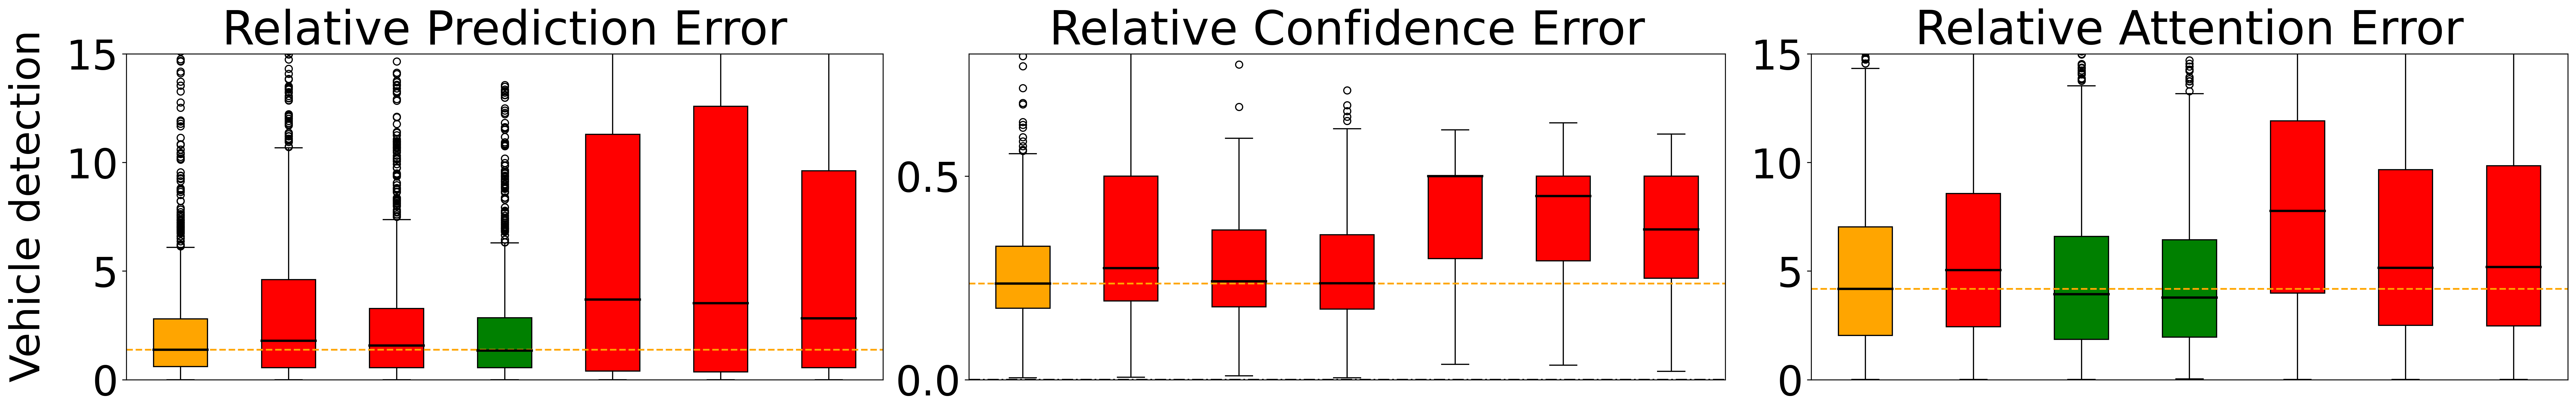

done


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import statistics

# Define the desired x-axis labels
# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
#                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]

source_names_plot = ["Sim", "C1", "C2", "C3", 
                     "P1", "P2", "P3"]

fig, axes = plt.subplots(1, 3, figsize=(30, 5), dpi=300)

# PLOT 1
all_model_errors1 = []
relative_model_errors1 = []

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            model_errors = model_loss_dict[model_type + "__" + source_name]
            all_model_errors1.append(model_errors)
            relative_loss = [abs(b_i - a_i) for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type + "__" + source_name])]
            relative_model_errors1.append(relative_loss)
            print("model error ",model_type,source_name)
            if source_name != 'sim':
                run_wilcoxon_and_cohend(model_loss_dict["sim__sim"], model_loss_dict[model_type + "__" + source_name])

if type == "kitti":
    relative_model_errors1 = [[error / (1242) for error in errors] for errors in relative_model_errors1]
    percentile90 = np.percentile(np.hstack(relative_model_errors1), 90)
    for i, model_errors in enumerate(all_model_errors1):
        relative_model_errors1[i] = [error for error in relative_model_errors1[i] if error <= percentile90]
sim_errors1 = relative_model_errors1[source_names.index("sim")]
sim_median1 = statistics.median(sim_errors1)

boxes1 = axes[0].boxplot(relative_model_errors1, vert=True, patch_artist=True)
axes[0].axhline(sim_median1, color='orange', linestyle='--', label='Median of "Sim"')
axes[0].tick_params(axis='y', labelsize=35)

for i, box in enumerate(boxes1['boxes']):
    box_median = np.median(relative_model_errors1[i])
    if box_median < sim_median1:
        box.set_facecolor('green')
    elif box_median == sim_median1:
        box.set_facecolor('orange')
    else:
        box.set_facecolor('red')

for median in boxes1['medians']:
    median.set_color('black')
    median.set_lw(2)
print("here")
if type=='donkey':
    axes[1].set_xticklabels(source_names_plot, rotation=0, fontsize=35)

# PLOT 2
all_model_errors2 = []
relative_model_errors2 = []

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            model_errors = model_att_dict[model_type + "__" + source_name]
            all_model_errors2.append(model_errors)
            relative_loss = [abs(a_i - b_i) for a_i, b_i in zip(model_att_dict["real__real"], model_att_dict[model_type + "__" + source_name])]
            relative_model_errors2.append(relative_loss)
            print("attention error ",model_type,source_name)
            run_wilcoxon_and_cohend(model_att_dict["real__real"], model_att_dict[model_type + "__" + source_name])

sim_errors2 = relative_model_errors2[source_names.index("sim")]
sim_median2 = statistics.median(sim_errors2)

boxes2 = axes[2].boxplot(relative_model_errors2, vert=True, patch_artist=True)
axes[2].axhline(sim_median2, color='orange', linestyle='--', label='Median of "Sim"')
axes[2].tick_params(axis='y', labelsize=35)

for i, box in enumerate(boxes2['boxes']):
    box_median = np.median(relative_model_errors2[i])
    if box_median < sim_median2:
        box.set_facecolor('green')
    elif box_median == sim_median2:
        box.set_facecolor('orange')
    else:
        box.set_facecolor('red')
print("here")
for median in boxes2['medians']:
    median.set_color('black')
    median.set_lw(2)
if type=='donkey':
    axes[2].set_xticklabels(source_names_plot, rotation=0, fontsize=35)

# PLOT 3
all_model_errors3 = []
relative_model_errors3 = []

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            model_errors = model_conf_dict[model_type + "__" + source_name]
            all_model_errors3.append(model_errors)
            if(type=='kitti'):
                relative_loss=[1-abs(abs(a_i-b_i)-a_i) if b_i>0.5 else  1-abs(abs(a_i-0.5)-a_i) for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
            else:
                relative_loss=[abs(a_i-b_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
            
            relative_model_errors3.append(relative_loss)
            print("confidence",model_type,source_name)
            run_wilcoxon_and_cohend(model_conf_dict["real__real"], model_conf_dict[model_type + "__" + source_name])

sim_errors3 = relative_model_errors3[source_names.index("sim")]
sim_median3 = statistics.median(sim_errors3)
print("here")
boxes3 = axes[1].boxplot(relative_model_errors3, vert=True, patch_artist=True)
axes[1].axhline(sim_median3, color='orange', linestyle='--', label='Median of "Sim"')
axes[1].tick_params(axis='y', labelsize=35)
axes[1].axhline(0, color='black', linestyle='dashdot', label='Median of "Sim"')
for i, box in enumerate(boxes3['boxes']):
    box_median = np.median(relative_model_errors3[i])
    if box_median > sim_median3:
        box.set_facecolor('red')
    elif box_median == sim_median3:
        box.set_facecolor('orange')
    else:
        box.set_facecolor('green')

for median in boxes3['medians']:
    median.set_color('black')
    median.set_lw(2)
print("here")
if type=='donkey':
    axes[0].set_xticklabels(source_names_plot, rotation=0, fontsize=35)

# Add a legend to the first subplot
legend_labels = ["Better than Sim", "Worse than Sim"]
legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
                   plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]

# Set titles for each subplot
if type=='kitti':
    axes[0].set_title("Relative Prediction Error", fontsize=40)
    axes[2].set_title("Relative Attention Error", fontsize=40)
    axes[1].set_title("Relative Confidence Error", fontsize=40)
# (Variance/20 predictions)
# Set a common y-axis label
if type=='donkey':
    fig.text(-0.01, 0.5, 'Lane keeping', ha='center', va='center', rotation='vertical', fontsize=35)
else:
    fig.text(-0.01, 0.5, 'Vehicle detection', ha='center', va='center', rotation='vertical', fontsize=35)
    axes[0].axes.get_xaxis().set_visible(False)
    axes[1].axes.get_xaxis().set_visible(False)
    axes[2].axes.get_xaxis().set_visible(False)
print("here")
axes[0].set_ylim(0,15)
axes[1].set_ylim(0,0.8)
axes[2].set_ylim(0,15)

# plt.legend(handles=legend_elements, fontsize=35, loc='lower center', bbox_to_anchor=(-1, -0.7), ncol=2)
# Save the merged plot as a PNG file
plt.tight_layout()
plt.savefig('merged_plot.png', dpi=500, bbox_inches='tight')
plt.show()
print("done")